In [1]:
# https://github.com/NikolayOskolkov/Physalia_MLOmicsIntegration_2025

In [2]:
setwd("./TESTS")
list.files()
getwd()

[1] "ENSEMBLE_TO_GENE_SYMBOL_MOUSE.txt" "scATACseq.txt"                    
[3] "scBSseq.txt"                       "scRNAseq.txt"

[1] "/home/tanasa/Desktop/MLomics/Physalia_MLOmics_Barcelona_2025_working_on/TESTS"

In [3]:
# https://biofam.github.io/MOFA2/

In [4]:
# scRNA

In [5]:
# scBSseq

In [6]:
# scATACseq 

In [7]:
# For scRNAseq OMICS layer we will only select highly expressed genes in order to remove noisy features that might contaminate the further downstream analysis. 
# We will also perform log-transform of the data which can be seen as a mild normalization:

In [9]:
library("mixOmics")
library("MOFA2")

In [10]:
# ?nearZeroVar
# predictors that have one unique value (i.e. are zero variance predictors) or predictors that are have both of 
# the following characteristics: they have very few unique values relative to the number of samples 
# and the ratio of the frequency of the most common value to the frequency of the second most common value is large

In [11]:
# Multi-OMICs Factor Analysis (MOFA) - FIXED VERSION
# Author: Fixed by Claude (original by Nikolay Oskolkov)
# Date: January 2026

# Set working directory (adjust as needed)
# setwd("/path/to/your/data")

# Load required libraries
library("mixOmics")
library("MOFA2")

In [ ]:
# While PCA is a pure matrix factorization technique which splits the total variance into orthogonal Principal Components (PCs), 
# Factor Analysis seeks to construct hidden latent variables that generate the observed data, 
# therefore Factor Analysis is a generative model.

In [12]:
# ========================================
# PART 1: READ AND PREPARE DATA
# ========================================

In [13]:
# Read scRNAseq data
scRNAseq <- read.delim("scRNAseq.txt", header = TRUE, check.names = FALSE, 
                       row.names = 1, sep = "\t")
ens2genesymbol <- read.delim("ENSEMBLE_TO_GENE_SYMBOL_MOUSE.txt")
ens2genesymbol <- ens2genesymbol[match(colnames(scRNAseq), 
                                       as.character(ens2genesymbol$ensembl_gene_id)),]
colnames(scRNAseq) <- ens2genesymbol$external_gene_name
scRNAseq <- as.data.frame(t(scRNAseq))

# Filter and transform scRNAseq
scRNAseq <- scRNAseq[rowMeans(scRNAseq) >= 1, ]
scRNAseq <- log10(scRNAseq + 1)
scRNAseq <- as.matrix(scRNAseq)  # Convert to matrix
cat("scRNAseq dimensions:", dim(scRNAseq), "\n")

scRNAseq dimensions: 12145 113 


In [14]:
# Read scBSseq data
scBSseq <- read.delim("scBSseq.txt", header = TRUE, check.names = FALSE, 
                      row.names = 1, sep = "\t")
scBSseq <- as.data.frame(t(scBSseq))

# Filter low variance features BEFORE binarizing
my_nearZeroVar <- nearZeroVar(as.data.frame(t(scBSseq)))
if(length(my_nearZeroVar$Position) > 0) {
  scBSseq <- scBSseq[-my_nearZeroVar$Position, ]
}
cat("scBSseq after first filter:", dim(scBSseq), "\n")

# Binarize scBSseq and ensure proper format
scBSseq <- ifelse(scBSseq < 50, 0, 1)
scBSseq <- as.matrix(scBSseq)  # Convert to matrix
storage.mode(scBSseq) <- "integer"  # Ensure integer type

# Filter low variance features AFTER binarizing
my_nearZeroVar <- nearZeroVar(as.data.frame(t(scBSseq)))
if(length(my_nearZeroVar$Position) > 0) {
  scBSseq <- scBSseq[-my_nearZeroVar$Position, ]
}

# Verify scBSseq is binary
cat("scBSseq unique values:", unique(as.vector(scBSseq)), "\n")
cat("scBSseq final dimensions:", dim(scBSseq), "\n")
cat("scBSseq value distribution:\n")
print(table(scBSseq))

scBSseq after first filter: 5285 113 
scBSseq unique values: 1 0 
scBSseq final dimensions: 4524 113 
scBSseq value distribution:
scBSseq
     0      1 
138227 372985 


In [15]:
# Read scATACseq data
scATACseq <- read.delim("scATACseq.txt", header = TRUE, check.names = FALSE, 
                        row.names = 1, sep = "\t")
scATACseq <- as.data.frame(t(scATACseq))

# Filter low variance features BEFORE binarizing
my_nearZeroVar <- nearZeroVar(as.data.frame(t(scATACseq)), uniqueCut = 1)
if(length(my_nearZeroVar$Position) > 0) {
  scATACseq <- scATACseq[-my_nearZeroVar$Position, ]
}
cat("scATACseq after first filter:", dim(scATACseq), "\n")

# Binarize scATACseq and ensure proper format
scATACseq <- ifelse(scATACseq < 50, 0, 1)
scATACseq <- as.matrix(scATACseq)  # Convert to matrix
storage.mode(scATACseq) <- "integer"  # Ensure integer type

# Filter low variance features AFTER binarizing
my_nearZeroVar <- nearZeroVar(as.data.frame(t(scATACseq)))
if(length(my_nearZeroVar$Position) > 0) {
  scATACseq <- scATACseq[-my_nearZeroVar$Position, ]
}

# Verify scATACseq is binary
cat("scATACseq unique values:", unique(as.vector(scATACseq)), "\n")
cat("scATACseq final dimensions:", dim(scATACseq), "\n")
cat("scATACseq value distribution:\n")
print(table(scATACseq))

scATACseq after first filter: 11709 113 
scATACseq unique values: 1 0 
scATACseq final dimensions: 9471 113 
scATACseq value distribution:
scATACseq
     0      1 
775841 294382 


In [ ]:
# MOFA learns LATENT FACTORS from variation.
# Features with (near) zero variance contain no information, destabilize inference, 
# and waste computation — so they must be removed.

In [64]:
# MOFA models each view as:

# X(v)≈W(v)Z

# where:

# X(v)  = features × samples
# W(v) = feature loadings
# Z = latent factors (shared across views)

In [65]:
dim(scRNAseq)

[1] 12145   113

In [66]:
dim(scBSseq)

[1] 4524  113

In [67]:
dim(scATACseq)

[1] 9471  113

In [68]:
# ========================================
# PART 2: VISUALIZE DATA DISTRIBUTIONS
# ========================================

# Let us now have a look at the histograms of individual OMICs layers in order to decide 
# what distribution they follow and how we should model these distributions with MOFA:

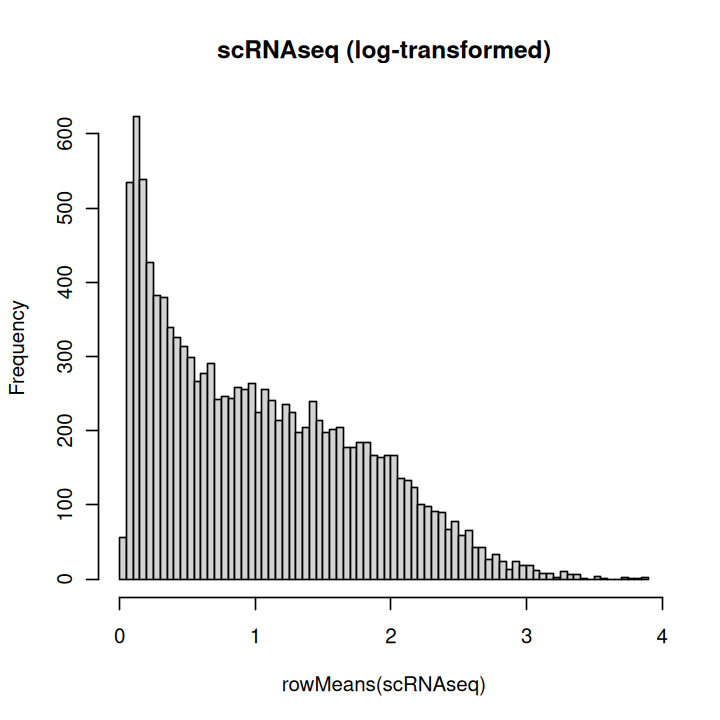

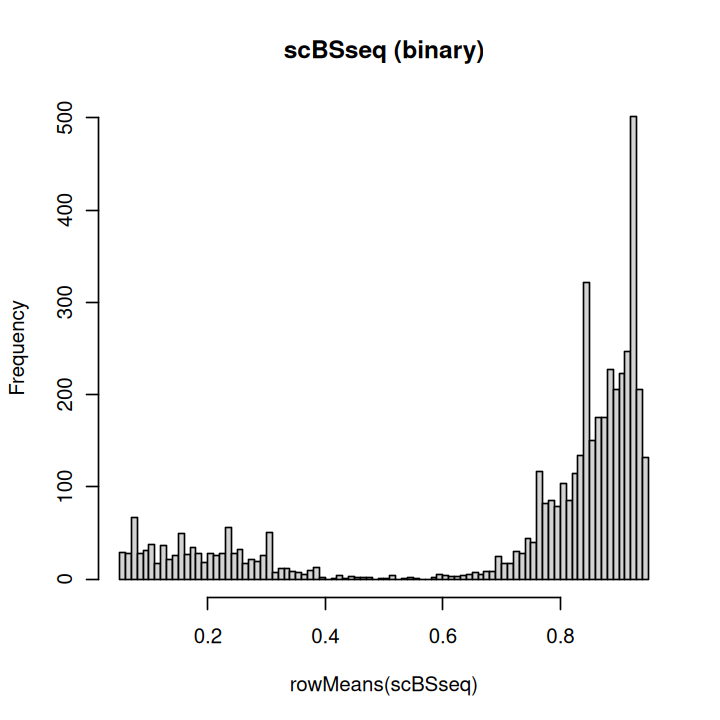

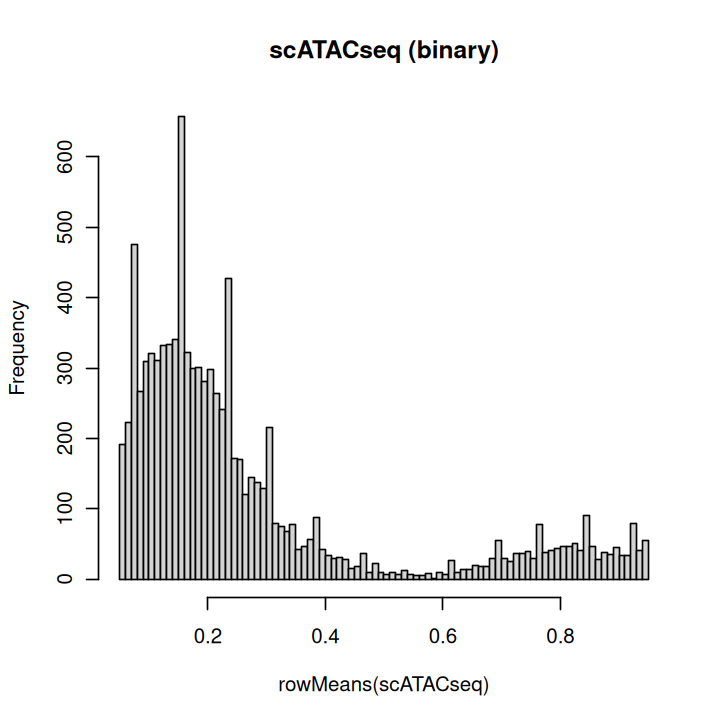

In [70]:
# Only plot if data exists
if(nrow(scRNAseq) > 0) {
  hist(rowMeans(scRNAseq), breaks = 100, main = "scRNAseq (log-transformed)")
}

if(nrow(scBSseq) > 0) {
  hist(rowMeans(scBSseq), breaks = 100, main = "scBSseq (binary)")
}

if(nrow(scATACseq) > 0) {
  hist(rowMeans(scATACseq), breaks = 100, main = "scATACseq (binary)")
}


In [71]:
# ========================================
# PART 3: CREATE AND RUN MOFA
# ========================================

# Create list of omics data (all as matrices)
omics <- list(
  scRNAseq = scRNAseq,
  scBSseq = scBSseq,
  scATACseq = scATACseq
)

# Verify data structure
cat("\n=== Data Summary ===\n")
lapply(omics, dim)
lapply(omics, class)
cat("\n=== Data ranges ===\n")
lapply(omics, function(x) range(x, na.rm = TRUE))



=== Data Summary ===


$scRNAseq
[1] 12145   113

$scBSseq
[1] 4524  113

$scATACseq
[1] 9471  113

$scRNAseq
[1] "matrix" "array" 

$scBSseq
[1] "matrix" "array" 

$scATACseq
[1] "matrix" "array"


=== Data ranges ===


$scRNAseq
[1] 0.000000 4.327031

$scBSseq
[1] 0 1

$scATACseq
[1] 0 1

In [ ]:
# We conclude that while scRNAseq data looks fairly Gaussian (or at least exponential), 
# we should probably model the scBSseq and scATACseq data following Bernoulli distribution 
# as they look quite bimodal indicating the binary nature of the data, 
# i.e. methylated vs. unmethylated for scBSseq and open vs. close for scATACseq. 

# To make the scBSseq and scATACseq data purely Bernoulli-like, 
# we will further make the scBSseq and scATACseq data sets binary by encoding values below 50 as 0 and above 50 as 1. 
# Since binary data typically have vey low variation compared to continuous data, 
# we need to remove low-variance features in this case again.

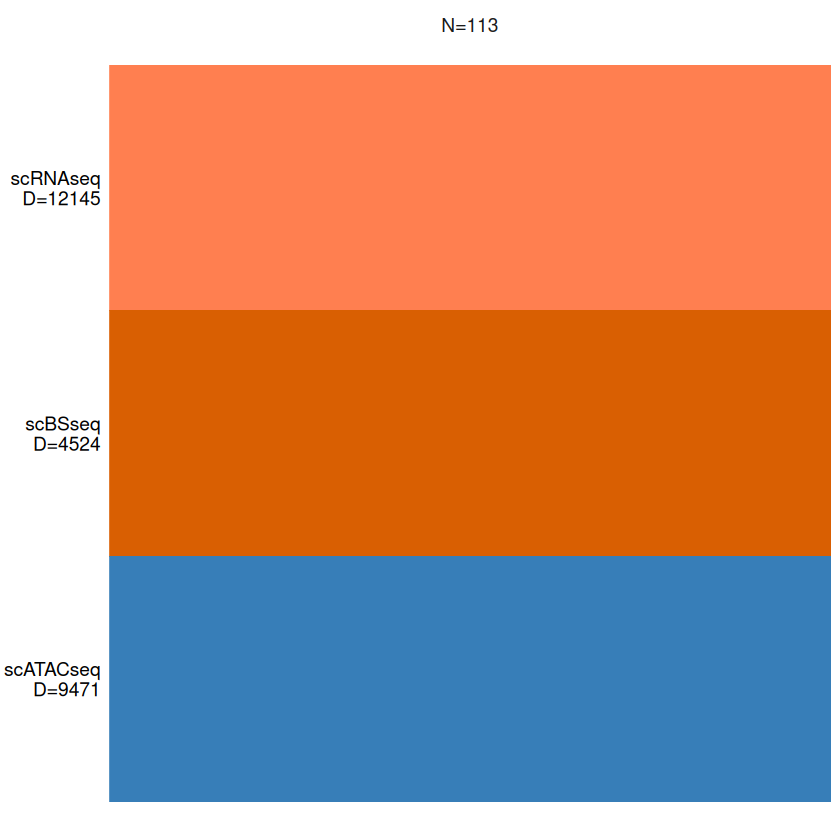

In [22]:
# Create MOFA object

MOFAobject <- create_mofa_from_matrix(omics)
plot_data_overview(MOFAobject)

In [73]:
# N = number of samples
# D = number of features (per view)

# D is view-specific
# It is the number of features used from that omics layer after preprocessing
# scRNAseq: D = 12,145 genes
# scBSseq: D = 4,524 CpGs / regions
# scATACseq: D = 9,471 peaks

In [23]:
# Define data options
DataOptions <- get_default_data_options(MOFAobject)
print(DataOptions)

# Define model options with correct distributions
ModelOptions <- get_default_model_options(MOFAobject)
mydistr <- c("gaussian", "bernoulli", "bernoulli")
names(mydistr) <- c("scRNAseq", "scBSseq", "scATACseq")
ModelOptions$likelihoods <- mydistr
ModelOptions$num_factors <- 20

cat("\n=== Model Options ===\n")
print(ModelOptions)

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] TRUE

$views
[1] "scRNAseq"  "scBSseq"   "scATACseq"

$groups
[1] "group1"


=== Model Options ===
$likelihoods
   scRNAseq     scBSseq   scATACseq 
 "gaussian" "bernoulli" "bernoulli" 

$num_factors
[1] 20

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] FALSE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE



In [25]:
# Define training options
TrainOptions <- get_default_training_options(MOFAobject)
TrainOptions$seed <- 2018
TrainOptions$drop_factor_threshold <- 0.03
TrainOptions$maxiter <- 1000
TrainOptions$verbose <- TRUE

print(TrainOptions)

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] 0.03

$verbose
[1] TRUE

$startELBO
[1] 1

$freqELBO
[1] 5

$stochastic
[1] FALSE

$gpu_mode
[1] FALSE

$gpu_device
NULL

$seed
[1] 2018

$outfile
NULL

$weight_views
[1] FALSE

$save_interrupted
[1] FALSE



In [26]:
# Prepare MOFA

MOFAobject <- prepare_mofa(
  MOFAobject, 
  data_options = DataOptions, 
  model_options = ModelOptions, 
  training_options = TrainOptions
)

Warning message in prepare_mofa(MOFAobject, data_options = DataOptions, model_options = ModelOptions, :
“Some view(s) have a lot of features, it is recommended to perform a more stringent feature selection before creating the MOFA object....”
Checking data options...

Checking training options...

Checking model options...



In [28]:
# Run MOFA with basilisk
cat("\n=== Running MOFA ===\n")
MOFAobject <- run_mofa(MOFAobject, use_basilisk = TRUE)

# Print results
print(MOFAobject)


=== Running MOFA ===


Warning message in run_mofa(MOFAobject, use_basilisk = TRUE):
“No output filename provided. Using /tmp/Rtmp1iA5sV/mofa_20260119-161533.hdf5 to store the trained model.

”
Connecting to the mofapy2 package using basilisk. 
    Set 'use_basilisk' to FALSE if you prefer to manually set the python binary using 'reticulate'.

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 1 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


Trained MOFA with the following characteristics: 
 Number of views: 3 
 Views names: scRNAseq scBSseq scATACseq 
 Number of features (per view): 12145 4524 9471 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 113 
 Number of factors: 3 



In [29]:
str(MOFAobject)

Formal class 'MOFA' [package "MOFA2"] with 20 slots
  ..@ data              :List of 3
  .. ..$ scRNAseq :List of 1
  .. .. ..$ group1: num [1:12145, 1:113] 0.245 0.354 0.589 0.611 -0.066 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:12145(1d)] "Mrpl15" "Lypla1" "Tcea1" "Atp6v1h" ...
  .. .. .. .. ..$ : chr [1:113(1d)] "ESC_A02" "ESC_A03" "ESC_A04" "ESC_A05" ...
  .. ..$ scBSseq  :List of 1
  .. .. ..$ group1: num [1:4524, 1:113] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:4524(1d)] "1_101935054" "1_101935061" "1_102002184" "1_102238204" ...
  .. .. .. .. ..$ : chr [1:113(1d)] "ESC_A02" "ESC_A03" "ESC_A04" "ESC_A05" ...
  .. ..$ scATACseq:List of 1
  .. .. ..$ group1: num [1:9471, 1:113] 1 0 0 0 0 1 0 1 0 0 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:9471(1d)] "1_100668590" "1_100994324" "1_100994328" "1_100994336" ...
  .. .. .. .. ..$ : chr [1:113(1d)] "ESC_A02" "ESC_A03"

In [ ]:
# ========================================
# PART 4: ANALYZE RESULTS
# ========================================

In [31]:
get_variance_explained(MOFAobject)

,scRNAseq,scBSseq,scATACseq
Factor1,6.923145,5.49092293,4.49208021
Factor2,3.559518,0.03377795,0.16059279
Factor3,3.318799,0.03517270,0.06973743


In [75]:
# ANALYZE RESULTS OF MOFA INTEGRATION



=== Variance Explained ===
 scRNAseq   scBSseq scATACseq 
13.339221  5.562508  4.713708 
        scRNAseq    scBSseq  scATACseq
Factor1 6.923145 5.49092293 4.49208021
Factor2 3.559518 0.03377795 0.16059279
Factor3 3.318799 0.03517270 0.06973743
[1] "Variance by factor"
[1] "Total variance"


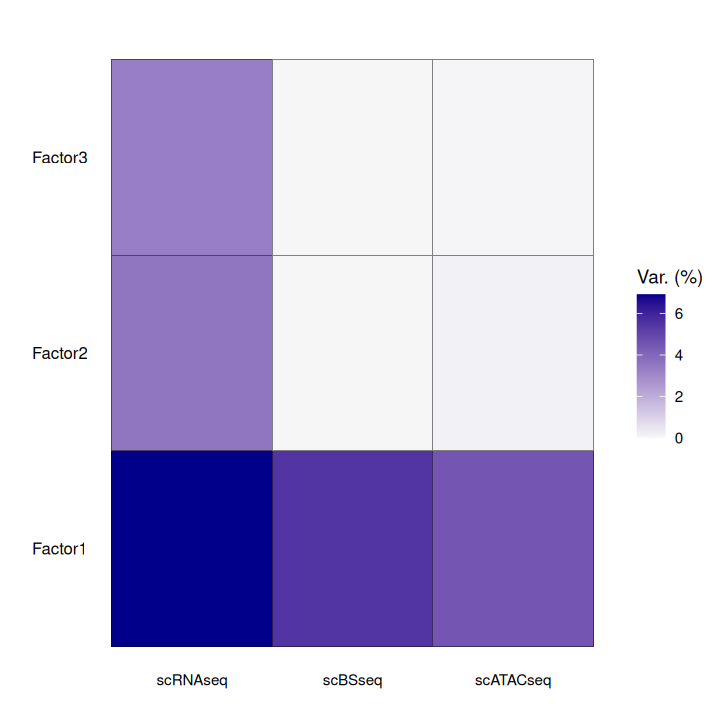


Number of factors: 3 


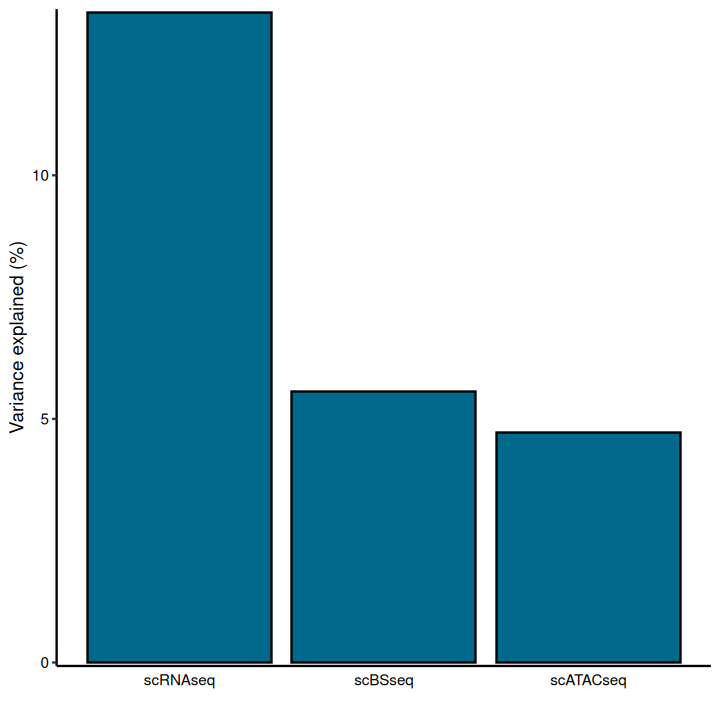

In [78]:
# Variance explained
cat("\n=== Variance Explained ===\n")
print(get_variance_explained(MOFAobject)$r2_total[[1]])
print(get_variance_explained(MOFAobject)$r2_per_factor[[1]])

# Plot variance explained
plot_list <- plot_variance_explained(MOFAobject, 
                                     x = 'view', 
                                     y = 'factor', 
                                     plot_total = TRUE)

print("Variance by factor")
print(plot_list[[1]])  # Variance by factor
print("Total variance")
print(plot_list[[2]])  # Total variance

# Get number of factors
NumFactors <- dim(get_factors(MOFAobject)$group1)[2]
cat("\nNumber of factors:", NumFactors, "\n")

In [ ]:
# ========================================
# PART 5: VISUALIZE FACTORS
# ========================================

In [80]:
# Increase the plot window size
options(repr.plot.width = 20, repr.plot.height = 6)  # For Jupyter

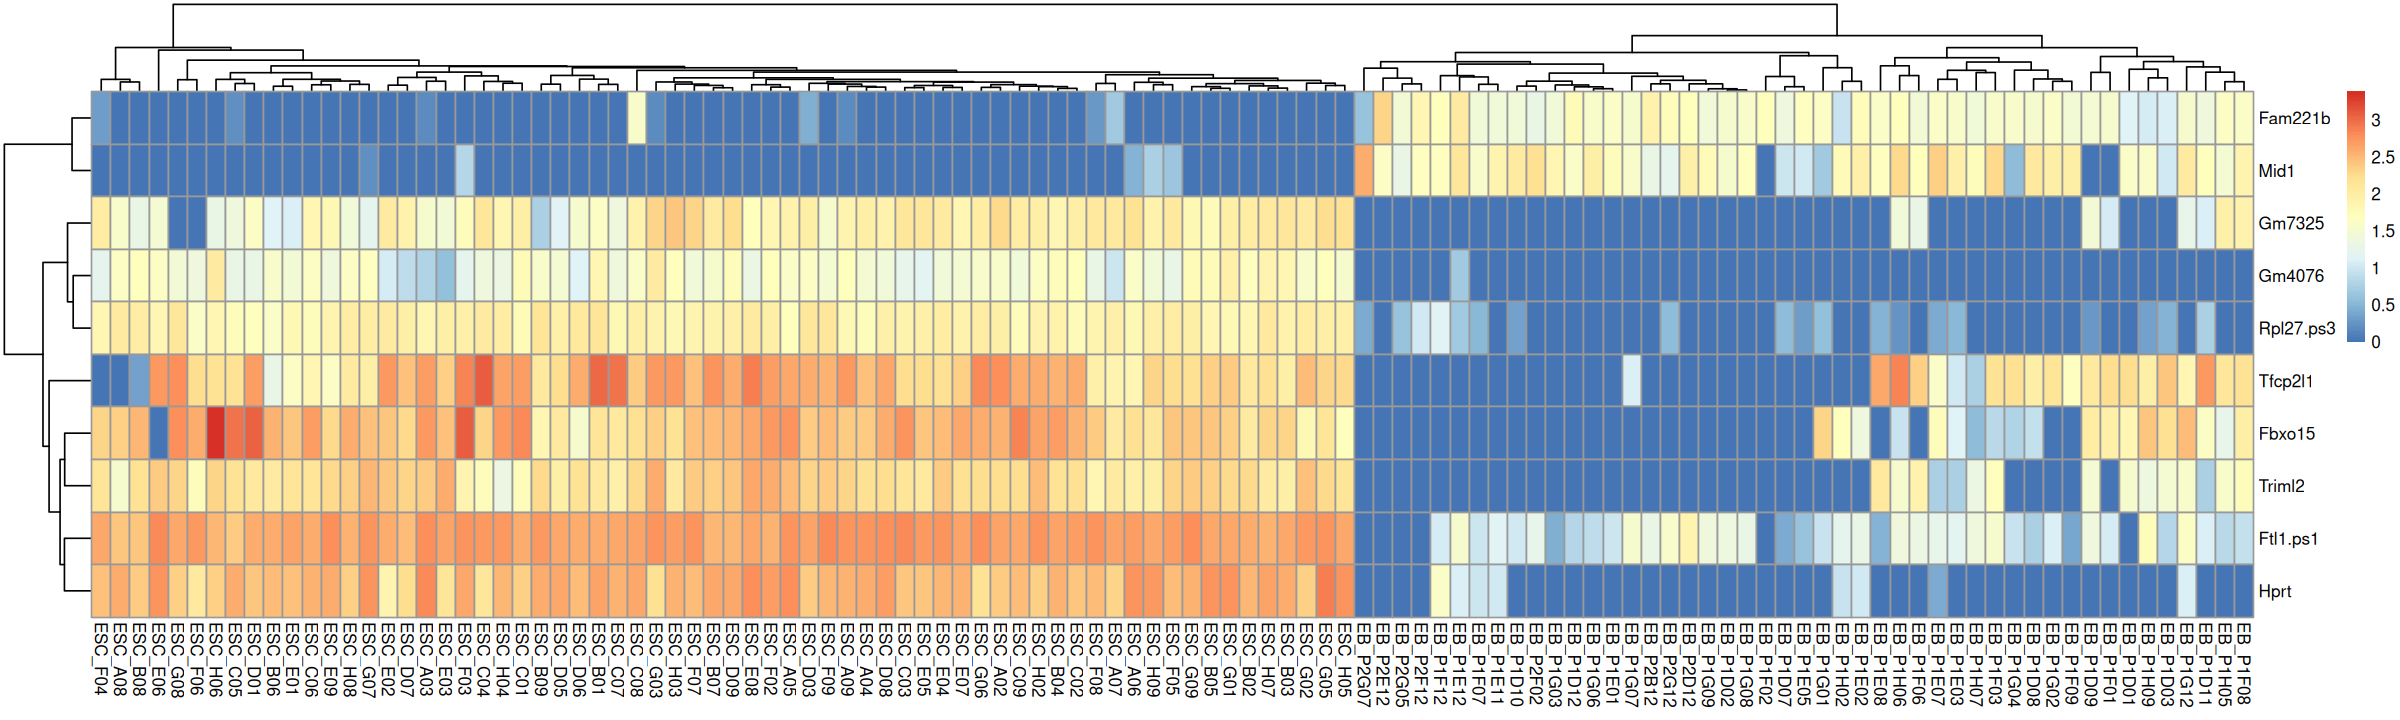

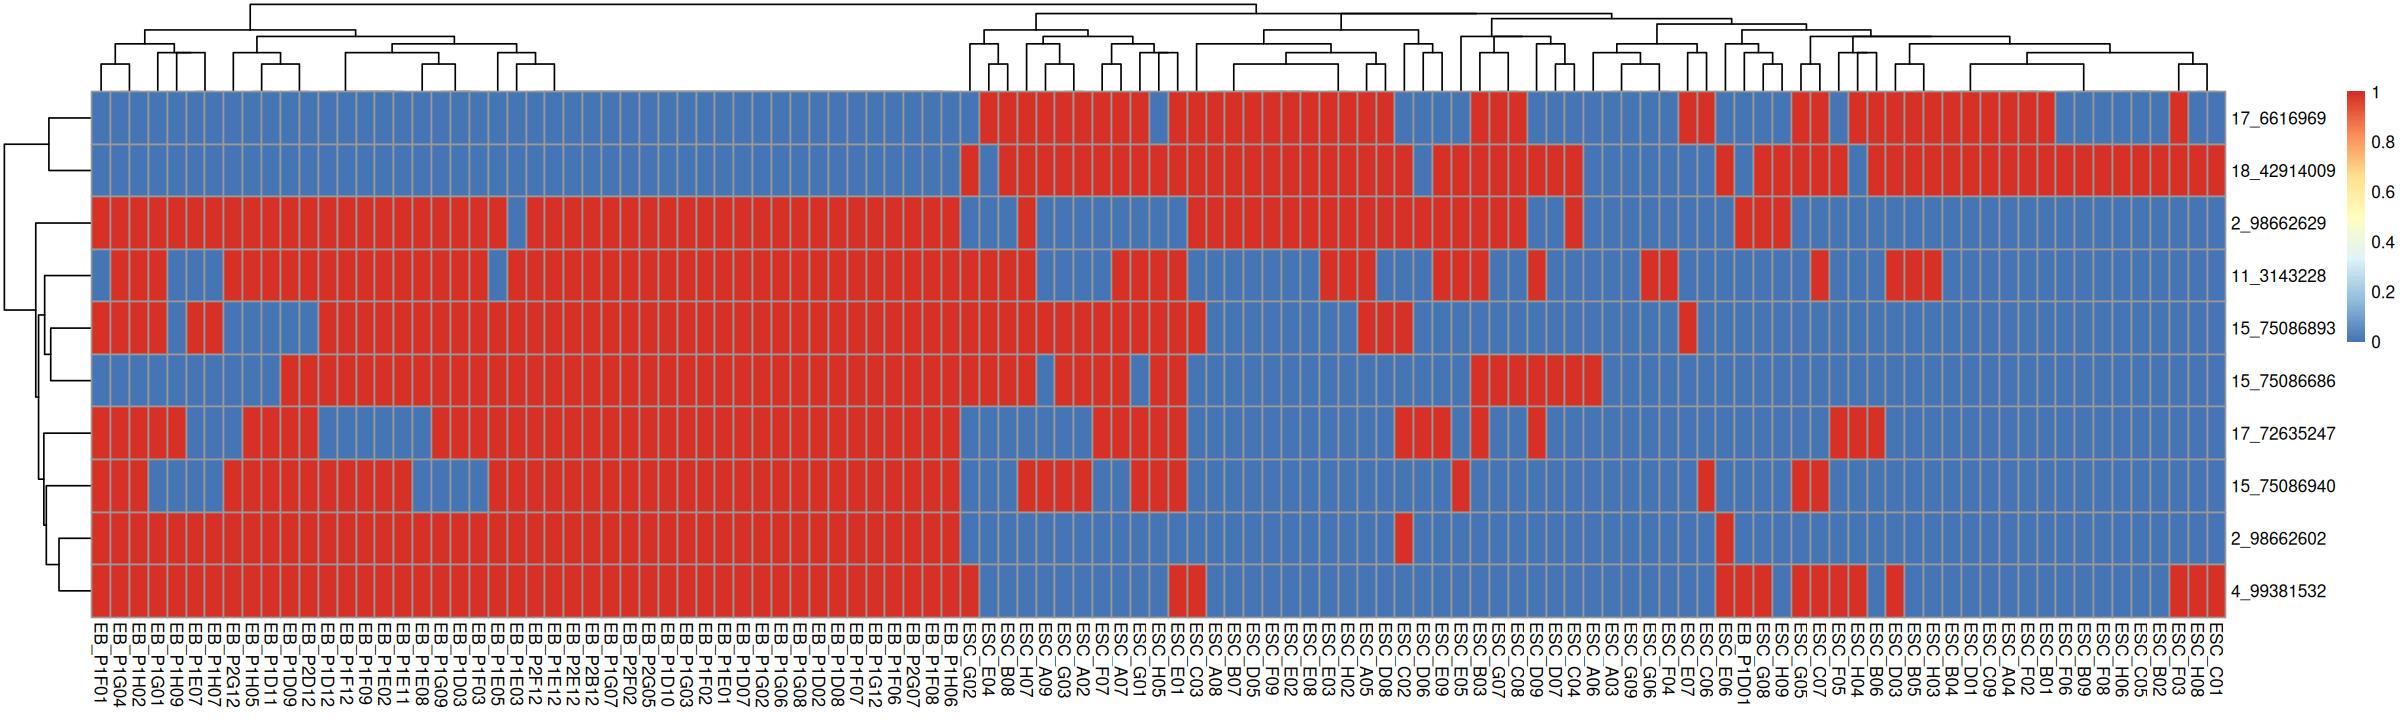

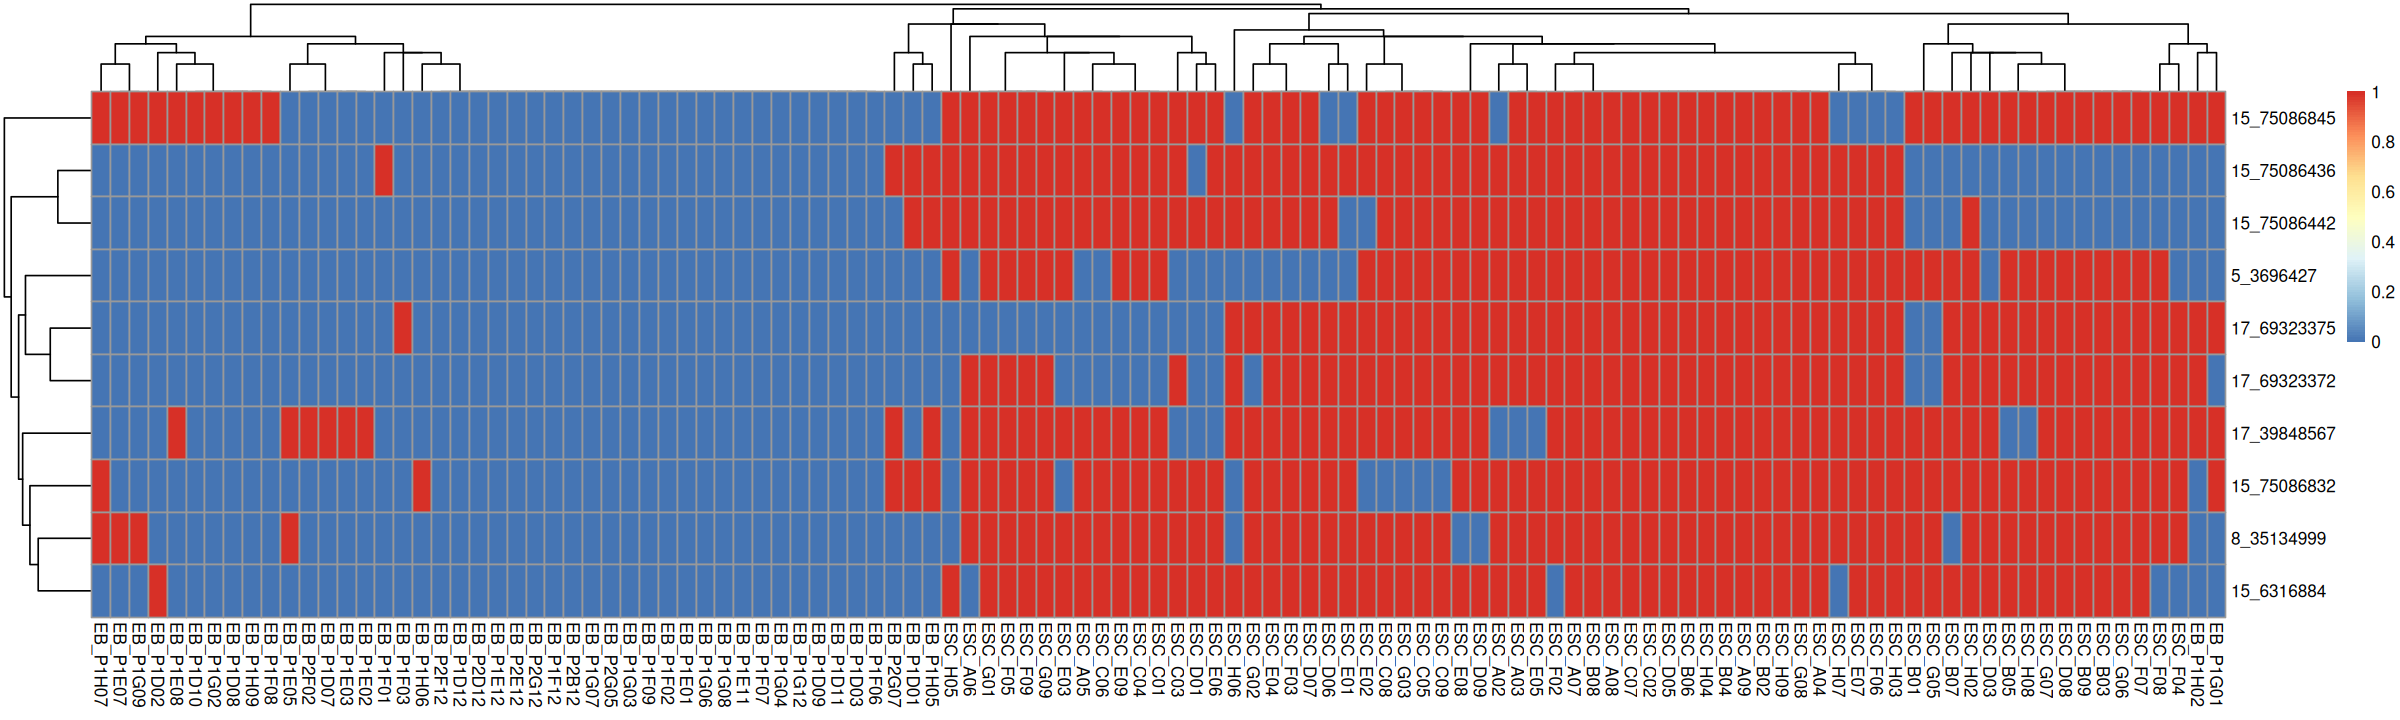

In [81]:
# Plot weights and top features for Factor 1
if(NumFactors >= 1) {
    
  # scRNAseq
  plot_weights(MOFAobject, 
               view = "scRNAseq", 
               factor = 1)
  plot_top_weights(MOFAobject, view = "scRNAseq", 
                   factor = 1, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, view = "scRNAseq", 
                   factor = "Factor1", 
                   features = 10, 
                   transpose = FALSE, 
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
  
  
    # scBSseq
  plot_weights(MOFAobject, 
               view = "scBSseq", 
               factor = 1)
  plot_top_weights(MOFAobject, 
                   view = "scBSseq", 
                   factor = 1, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scBSseq", 
                   factor = "Factor1", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
  
  
    # scATACseq
  plot_weights(MOFAobject, 
               view = "scATACseq", 
               factor = 1)
  plot_top_weights(MOFAobject, 
                   view = "scATACseq", 
                   factor = 1, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scATACseq", 
                   factor = "Factor1", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
}



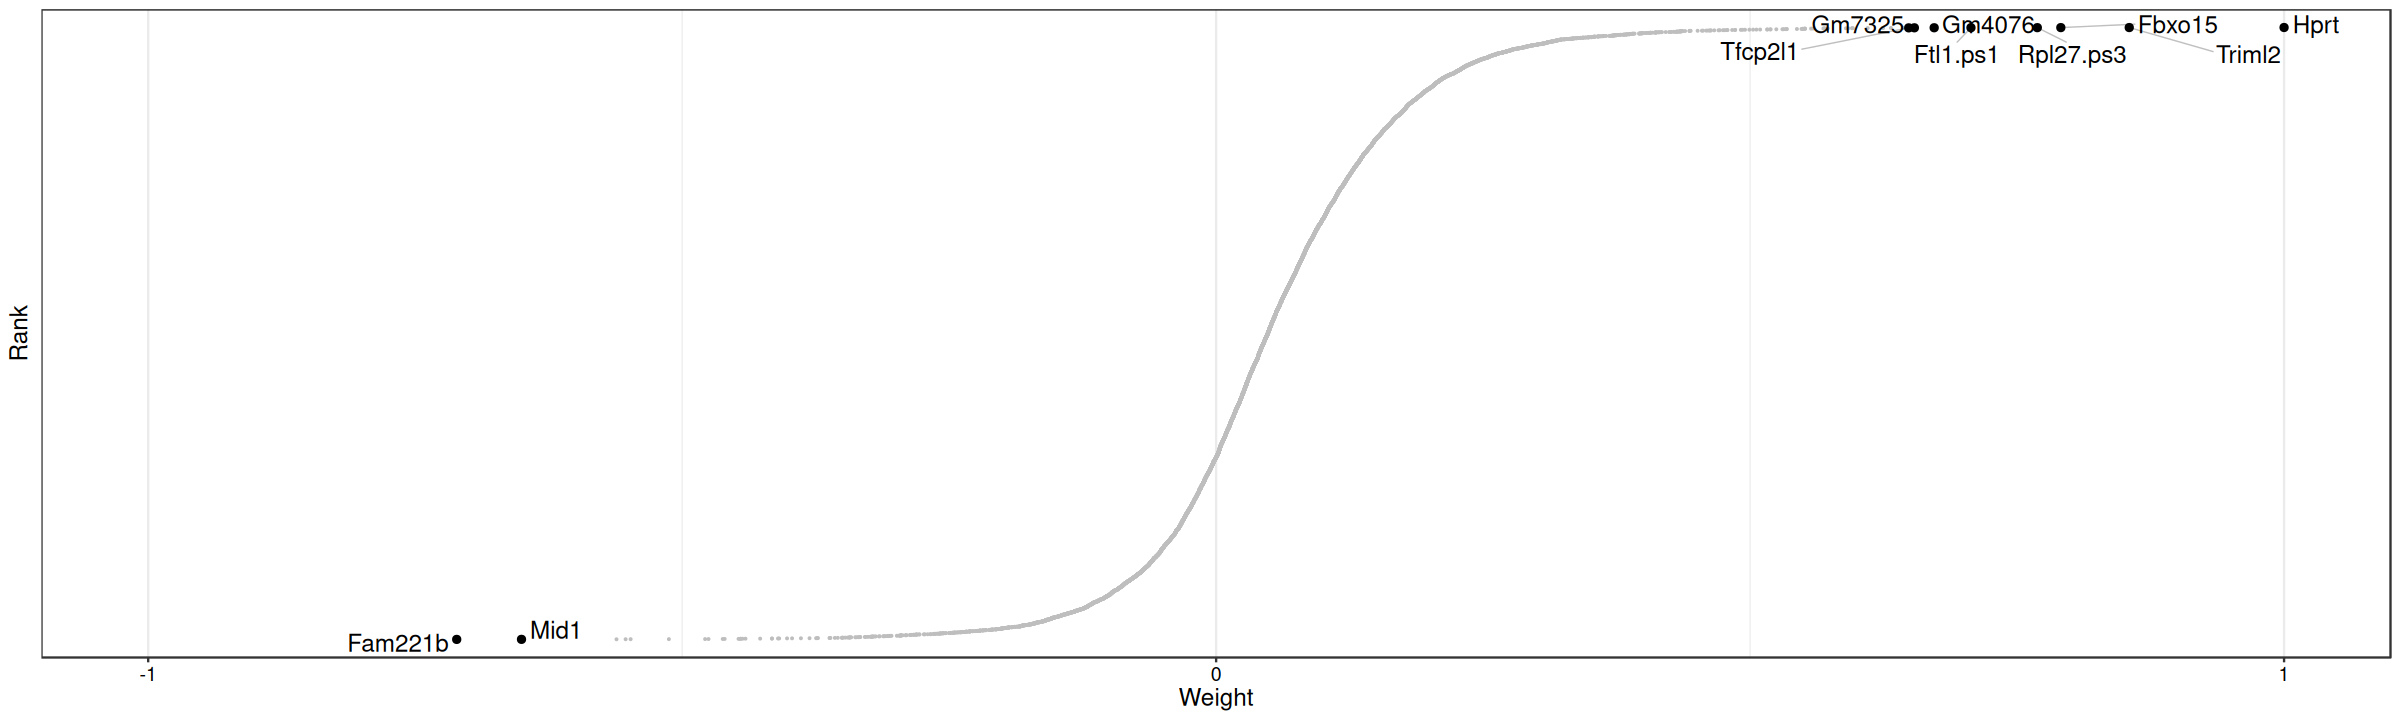

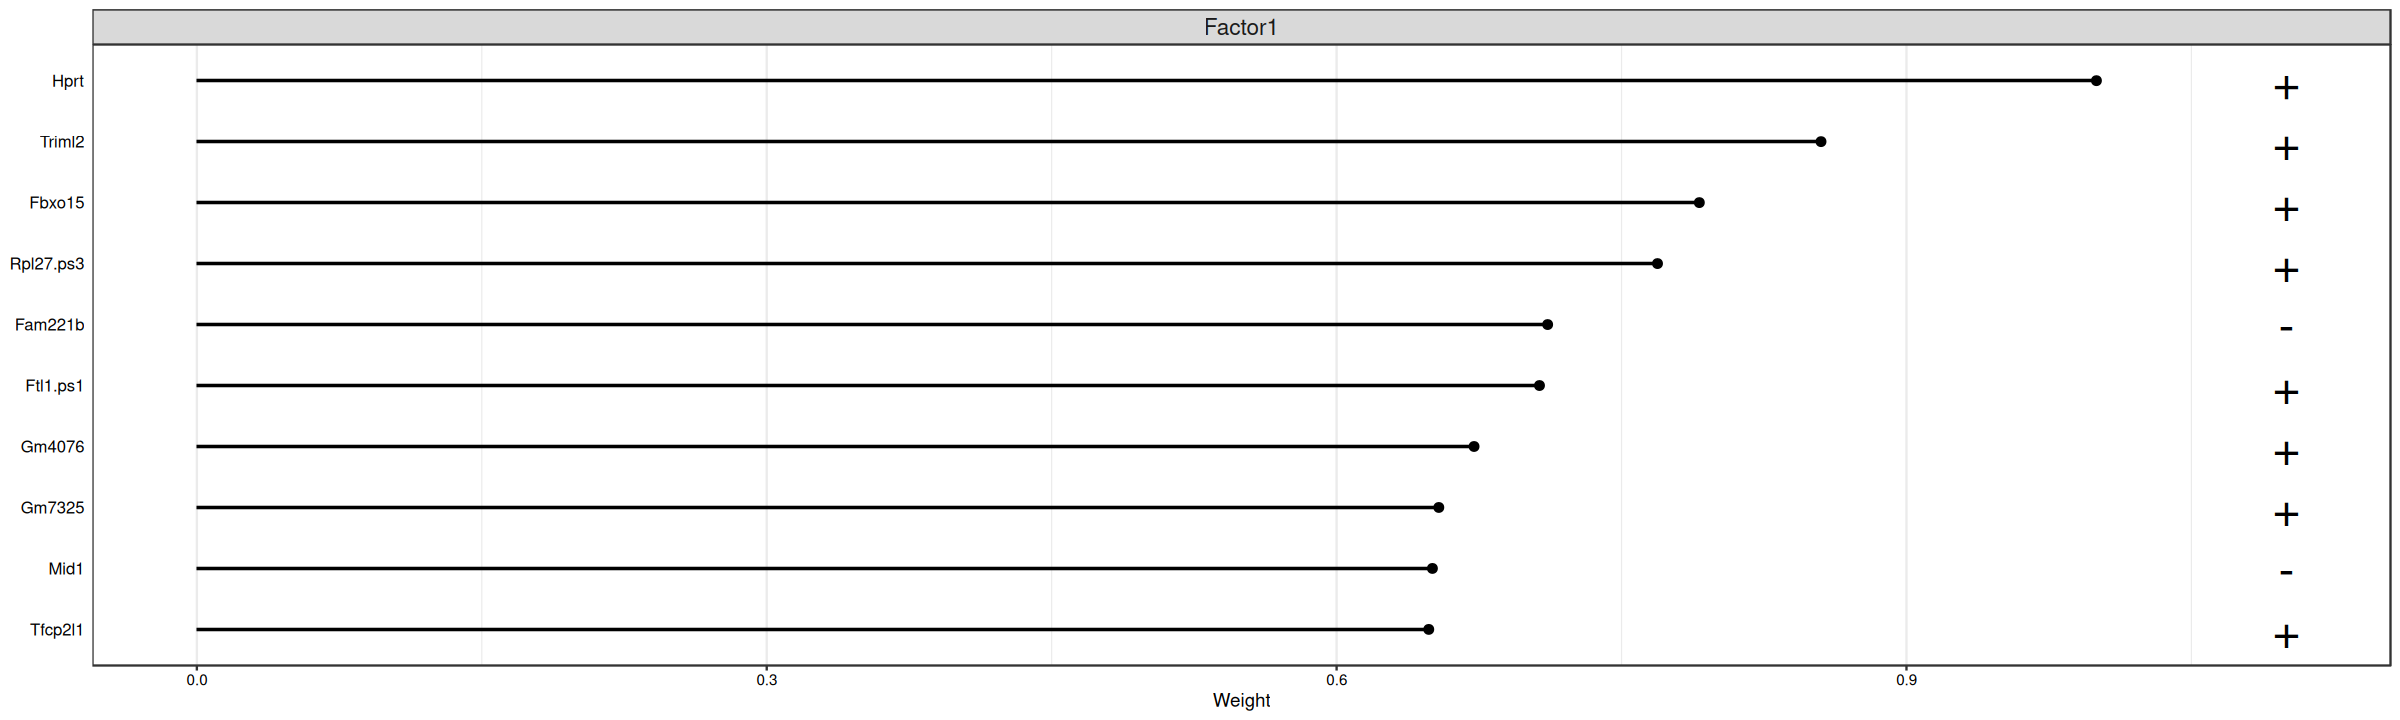

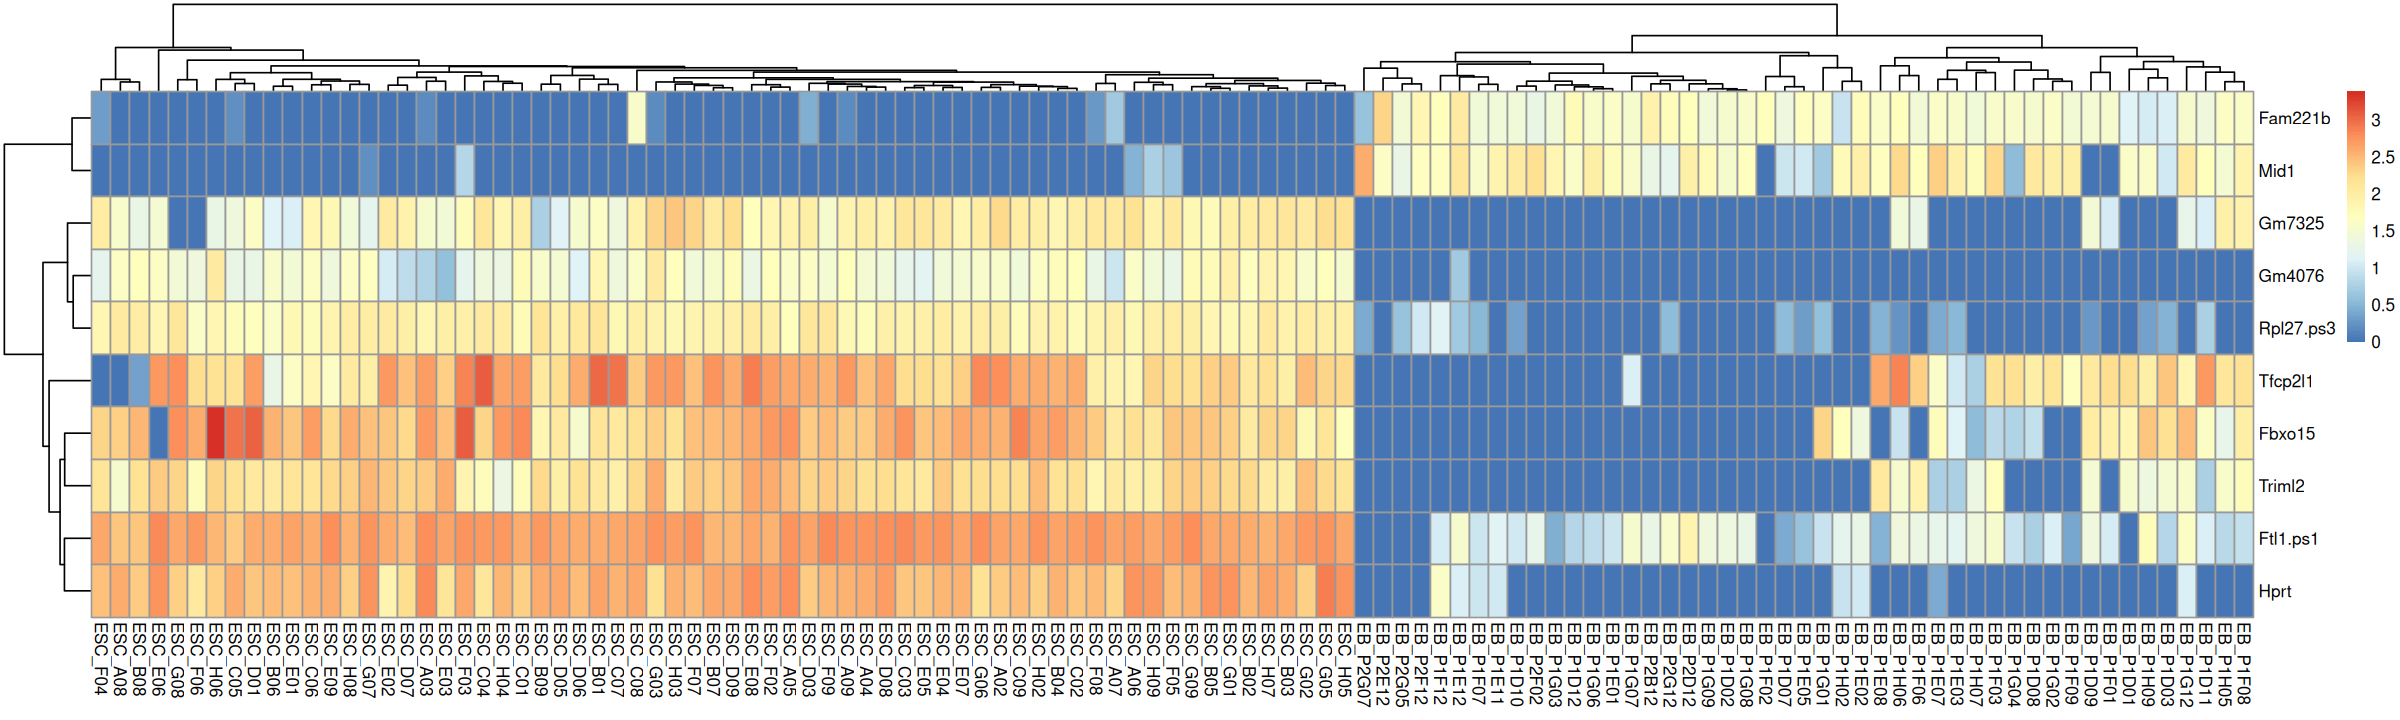

In [82]:
  # scRNAseq
  plot_weights(MOFAobject, 
               view = "scRNAseq", 
               factor = 1)
  plot_top_weights(MOFAobject, view = "scRNAseq", 
                   factor = 1, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, view = "scRNAseq", 
                   factor = "Factor1", 
                   features = 10, 
                   transpose = FALSE, 
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)

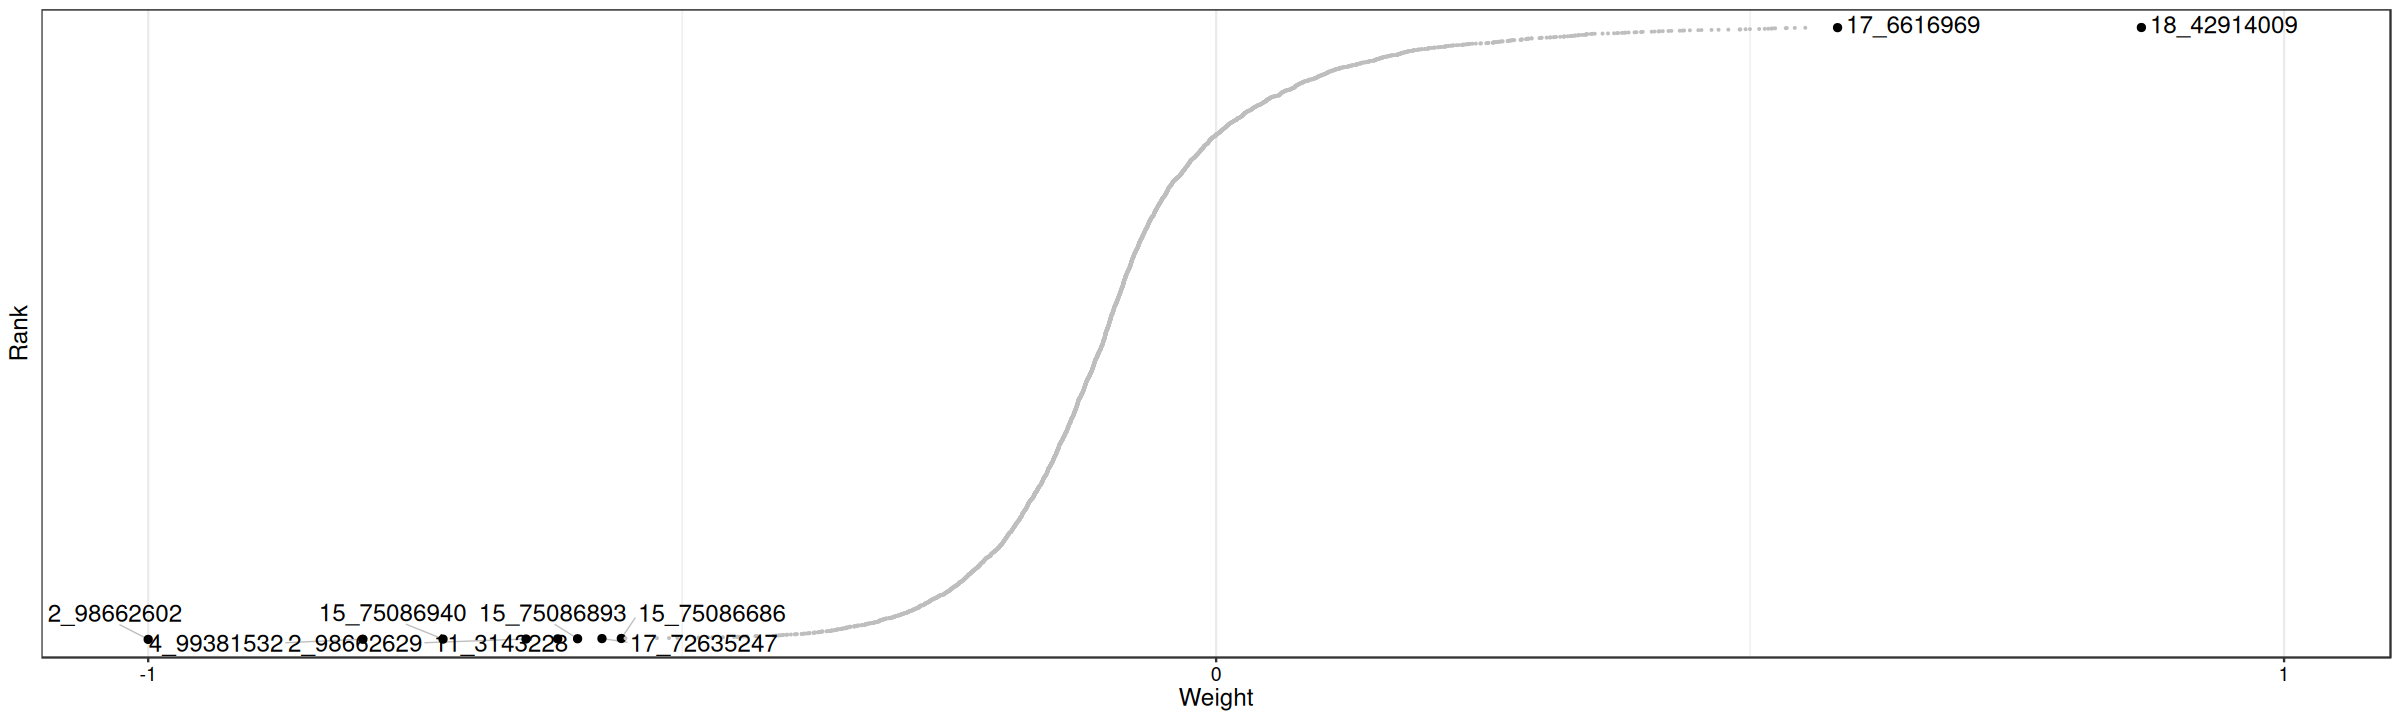

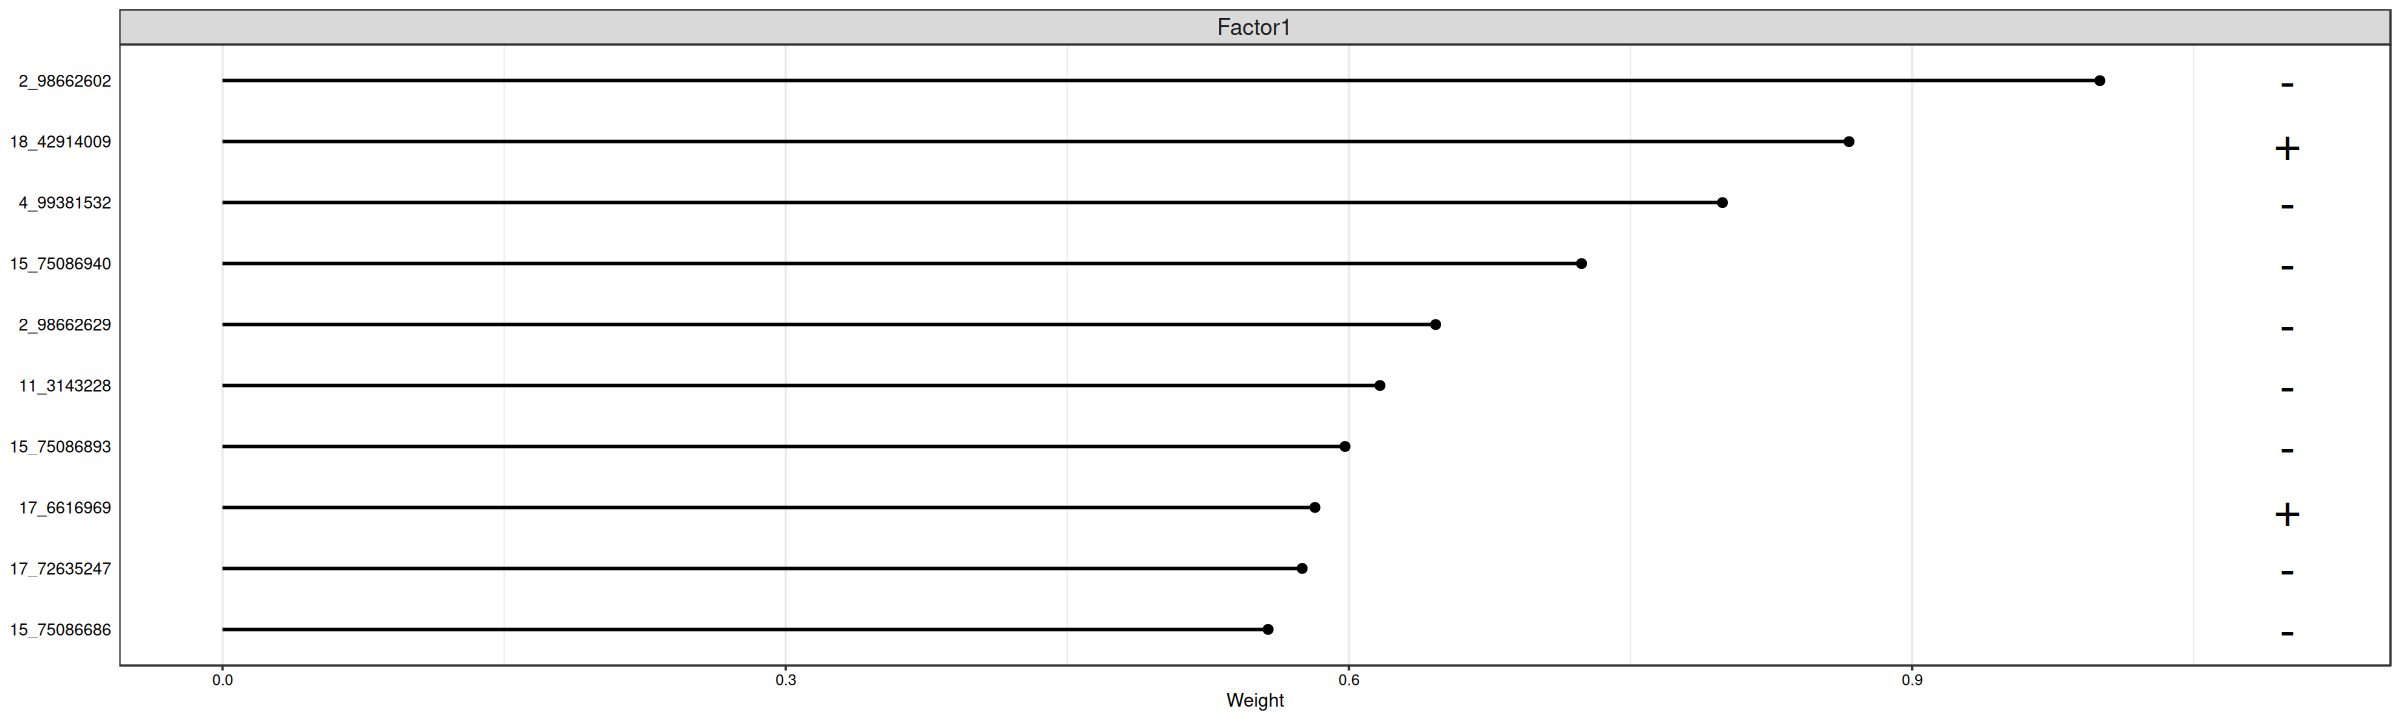

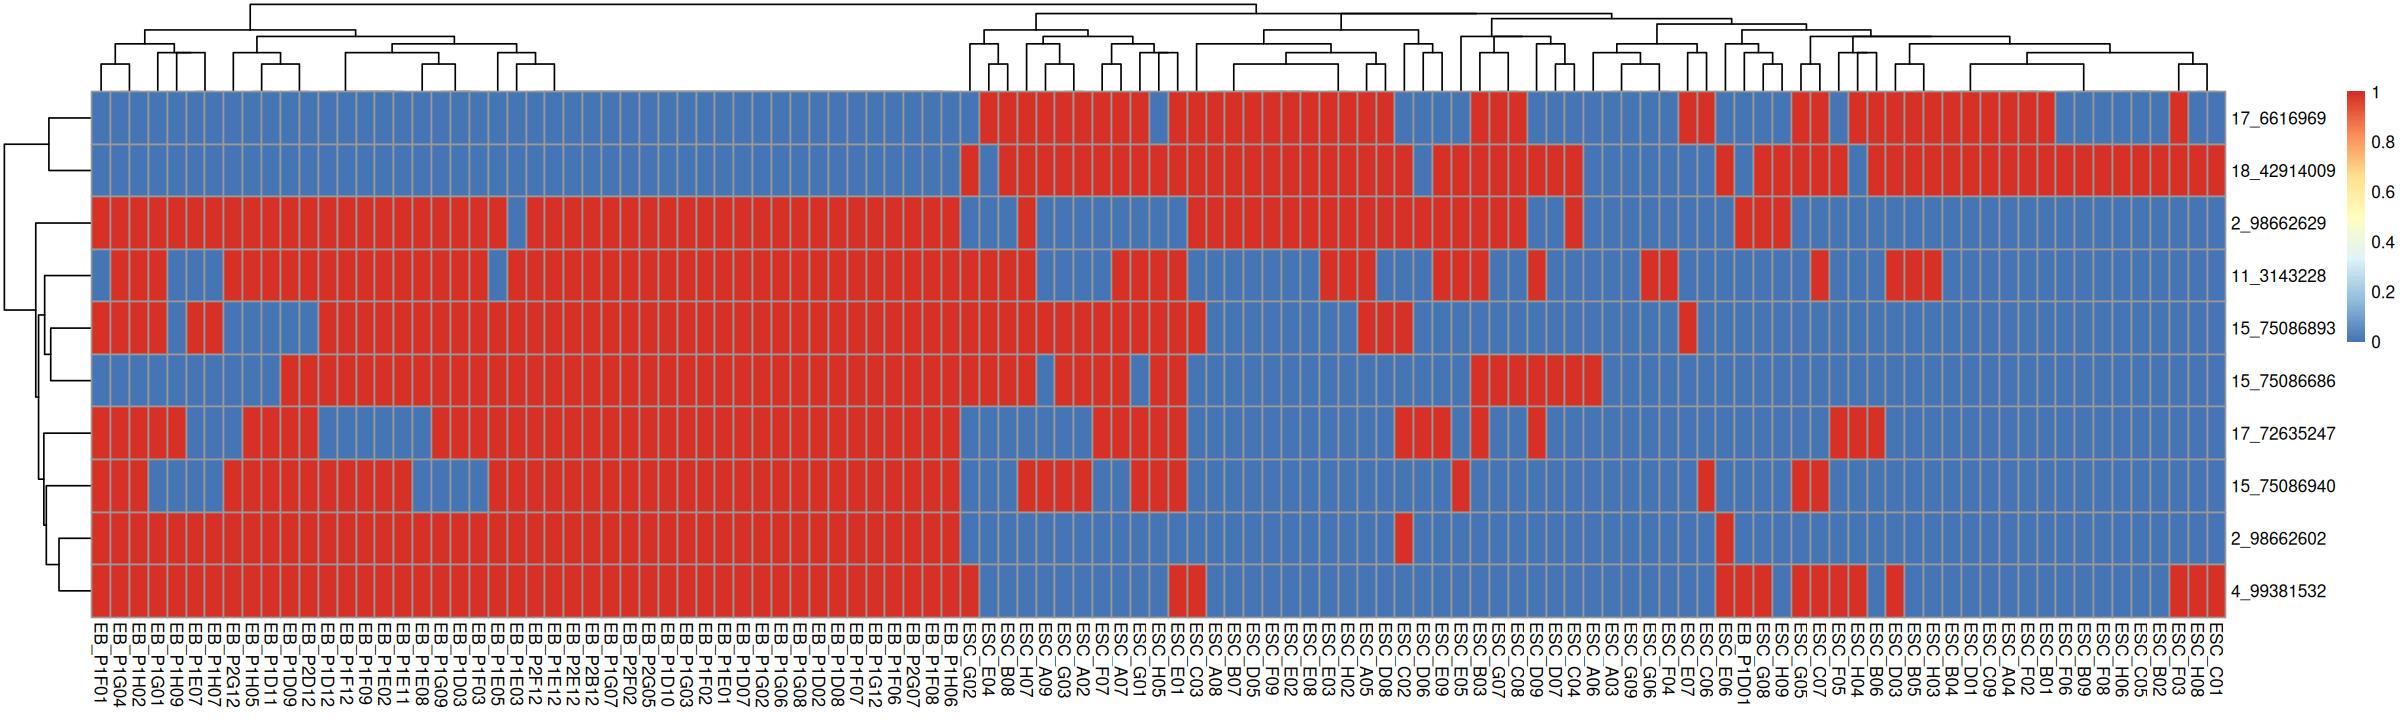

In [83]:
    # scBSseq
  plot_weights(MOFAobject, 
               view = "scBSseq", 
               factor = 1)
  plot_top_weights(MOFAobject, 
                   view = "scBSseq", 
                   factor = 1, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scBSseq", 
                   factor = "Factor1", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)

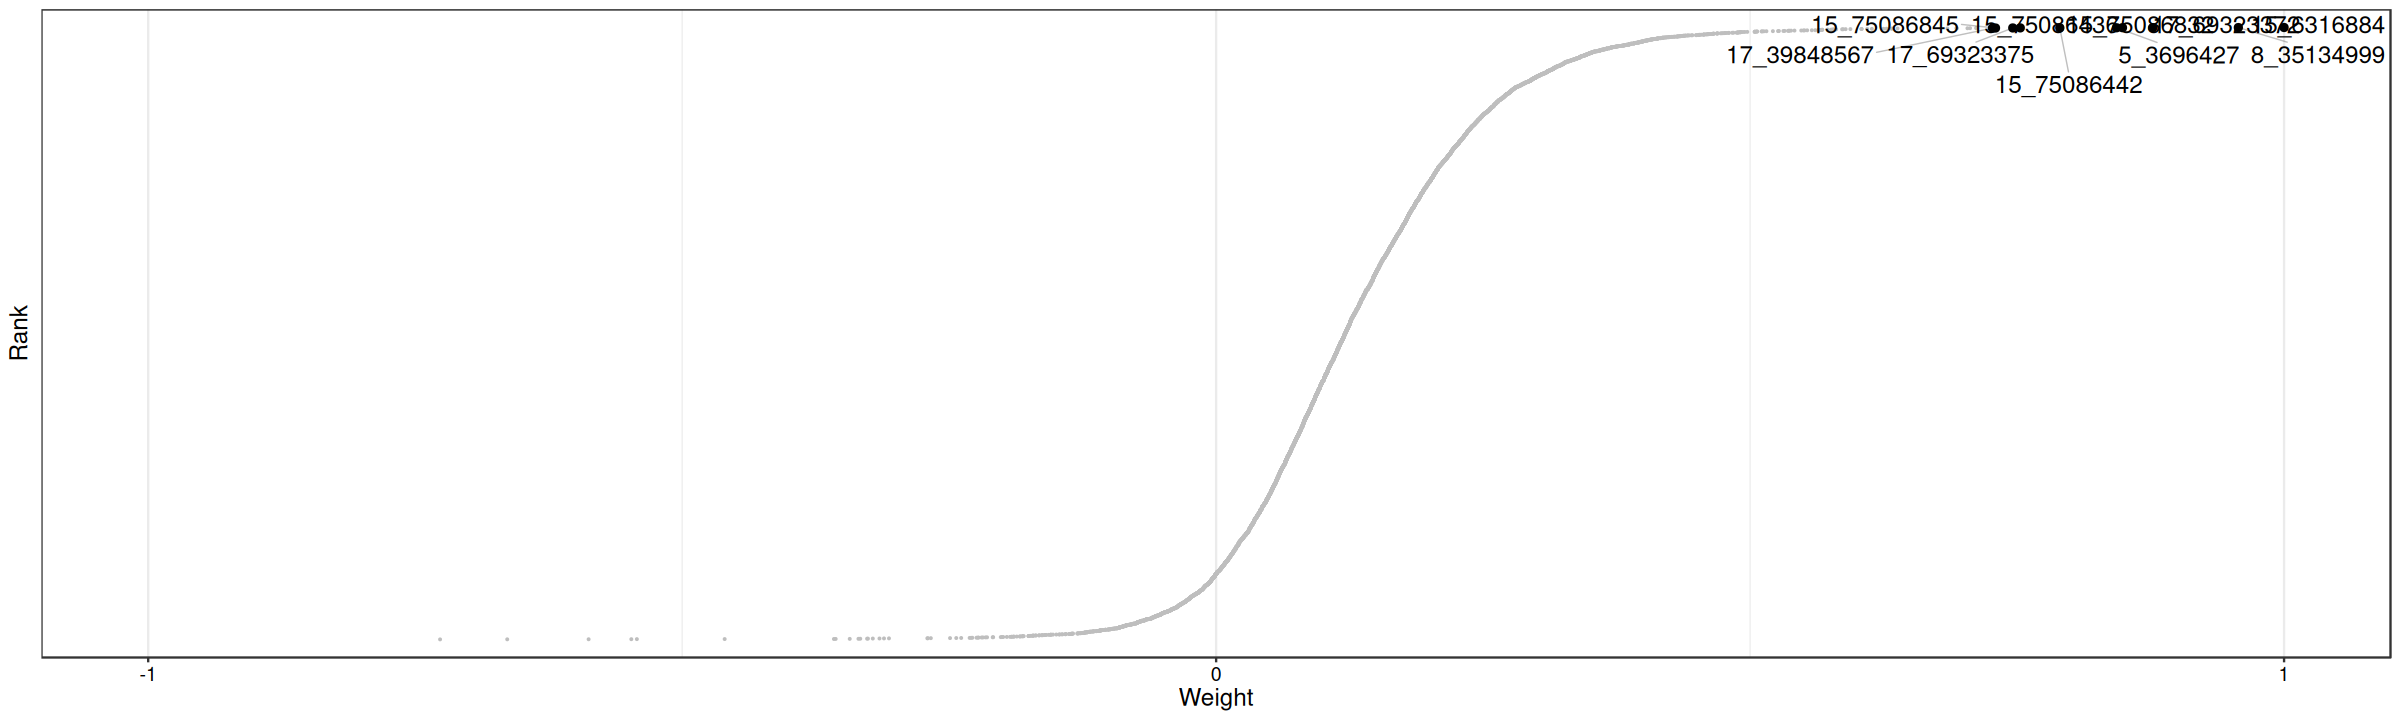

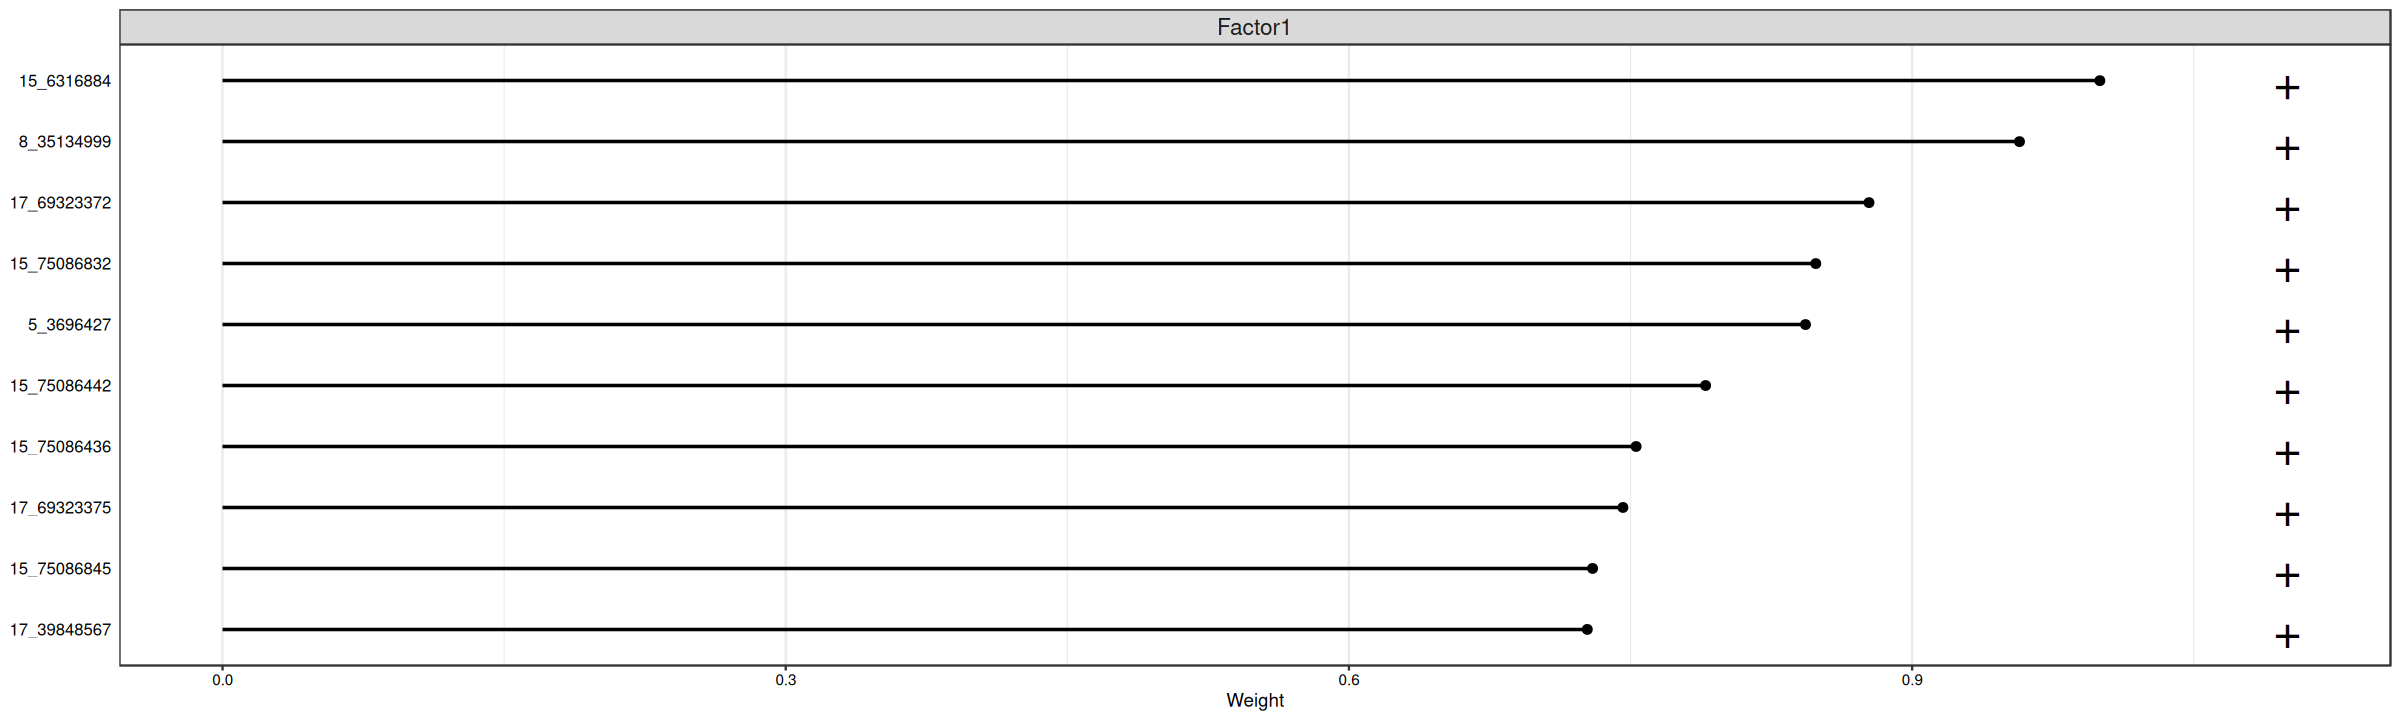

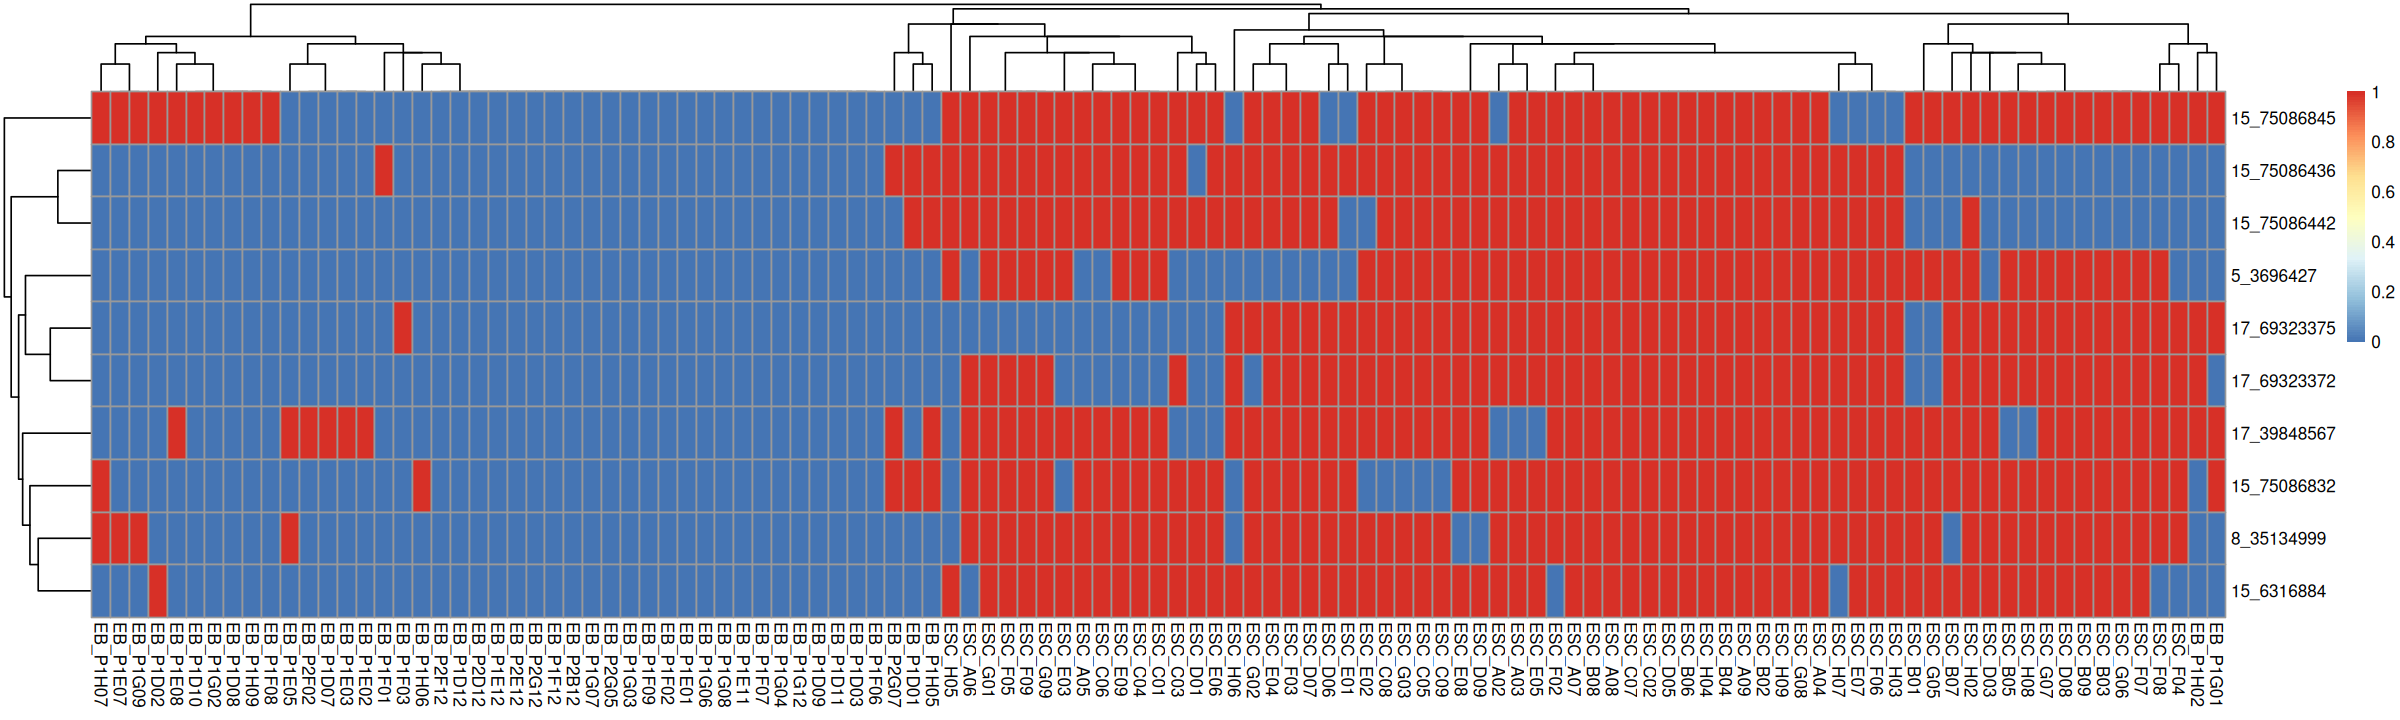

In [84]:
    # scATACseq
  plot_weights(MOFAobject, 
               view = "scATACseq", 
               factor = 1)
  plot_top_weights(MOFAobject, 
                   view = "scATACseq", 
                   factor = 1, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scATACseq", 
                   factor = "Factor1", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)

In [ ]:
# Rank vs Weight (distribution of loadings)

# What you see
# X-axis: Weight (loading value)
# Y-axis: Rank (ordered features)
# S-shaped curve

# Interpretation
# Most features have weights near 0 → they do not contribute to Factor 1
# A small tail of features have large positive weights
# (Likely also a small negative tail, though here positives dominate)
# 👉 This tells you:
# Factor 1 is sparse and driven by a small subset of highly informative features, not by everything.

# On the heatmap : 

# Cells split into two major blocks
# One block has:
# mostly red for these features
# The other block:
# mostly blue
# This aligns with:
# Factor 1 separating two cell populations

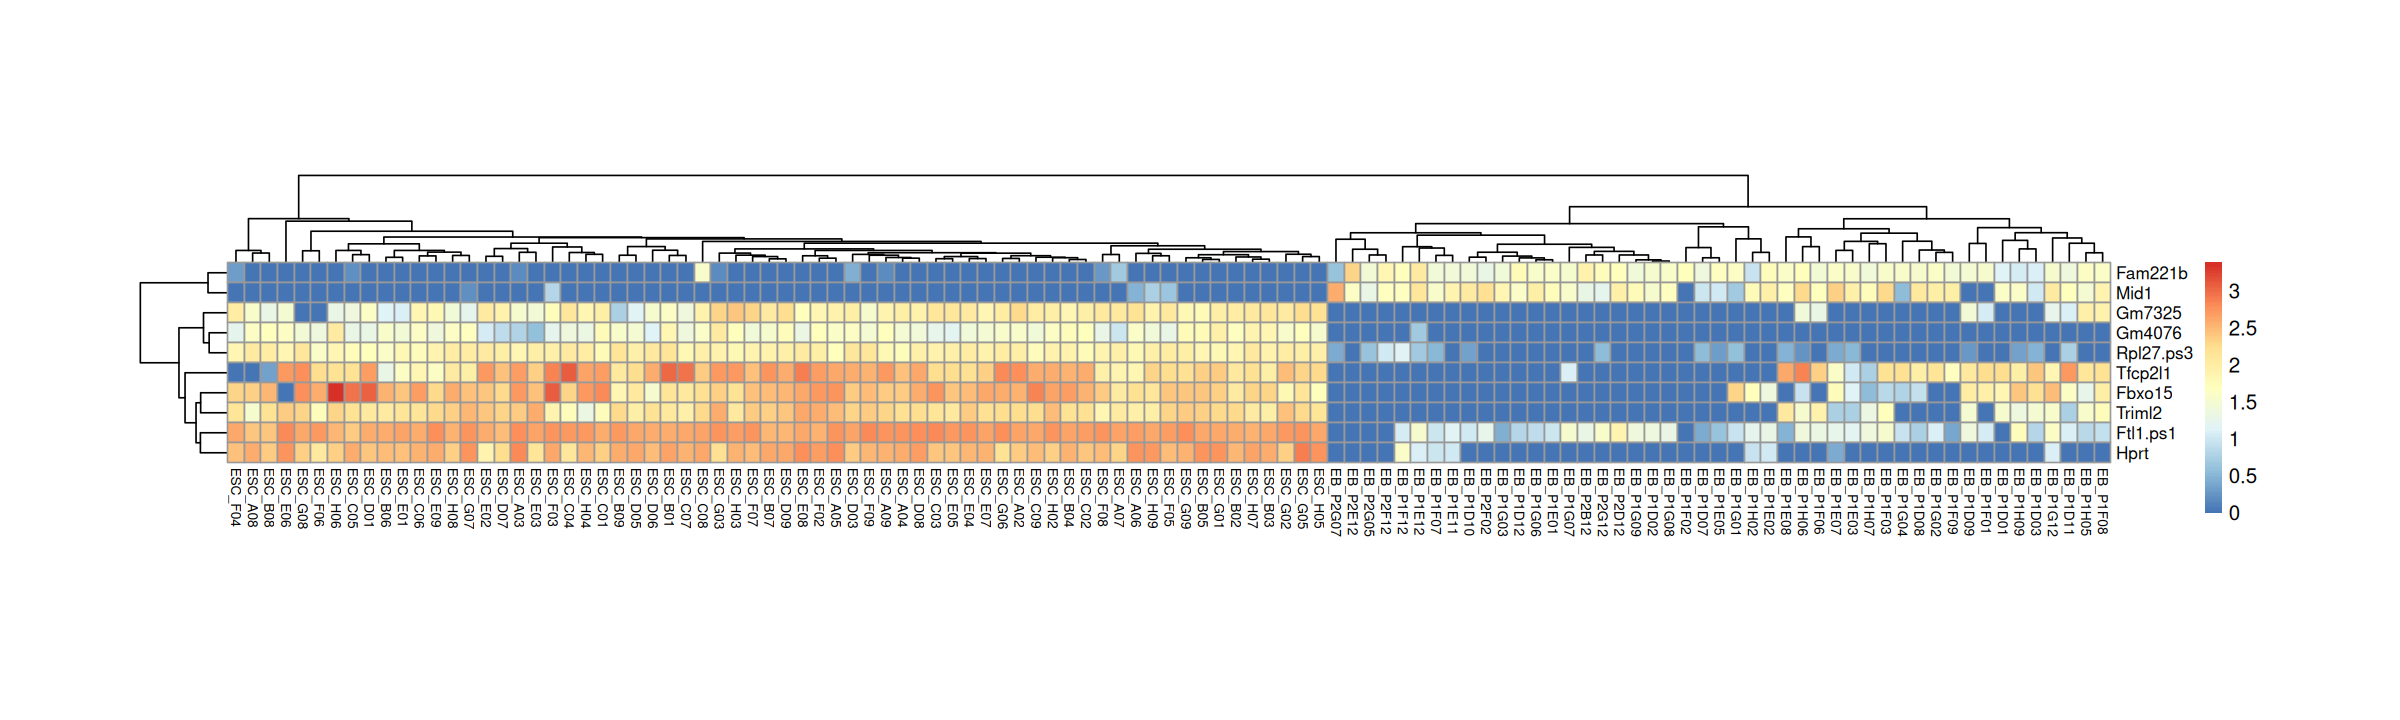

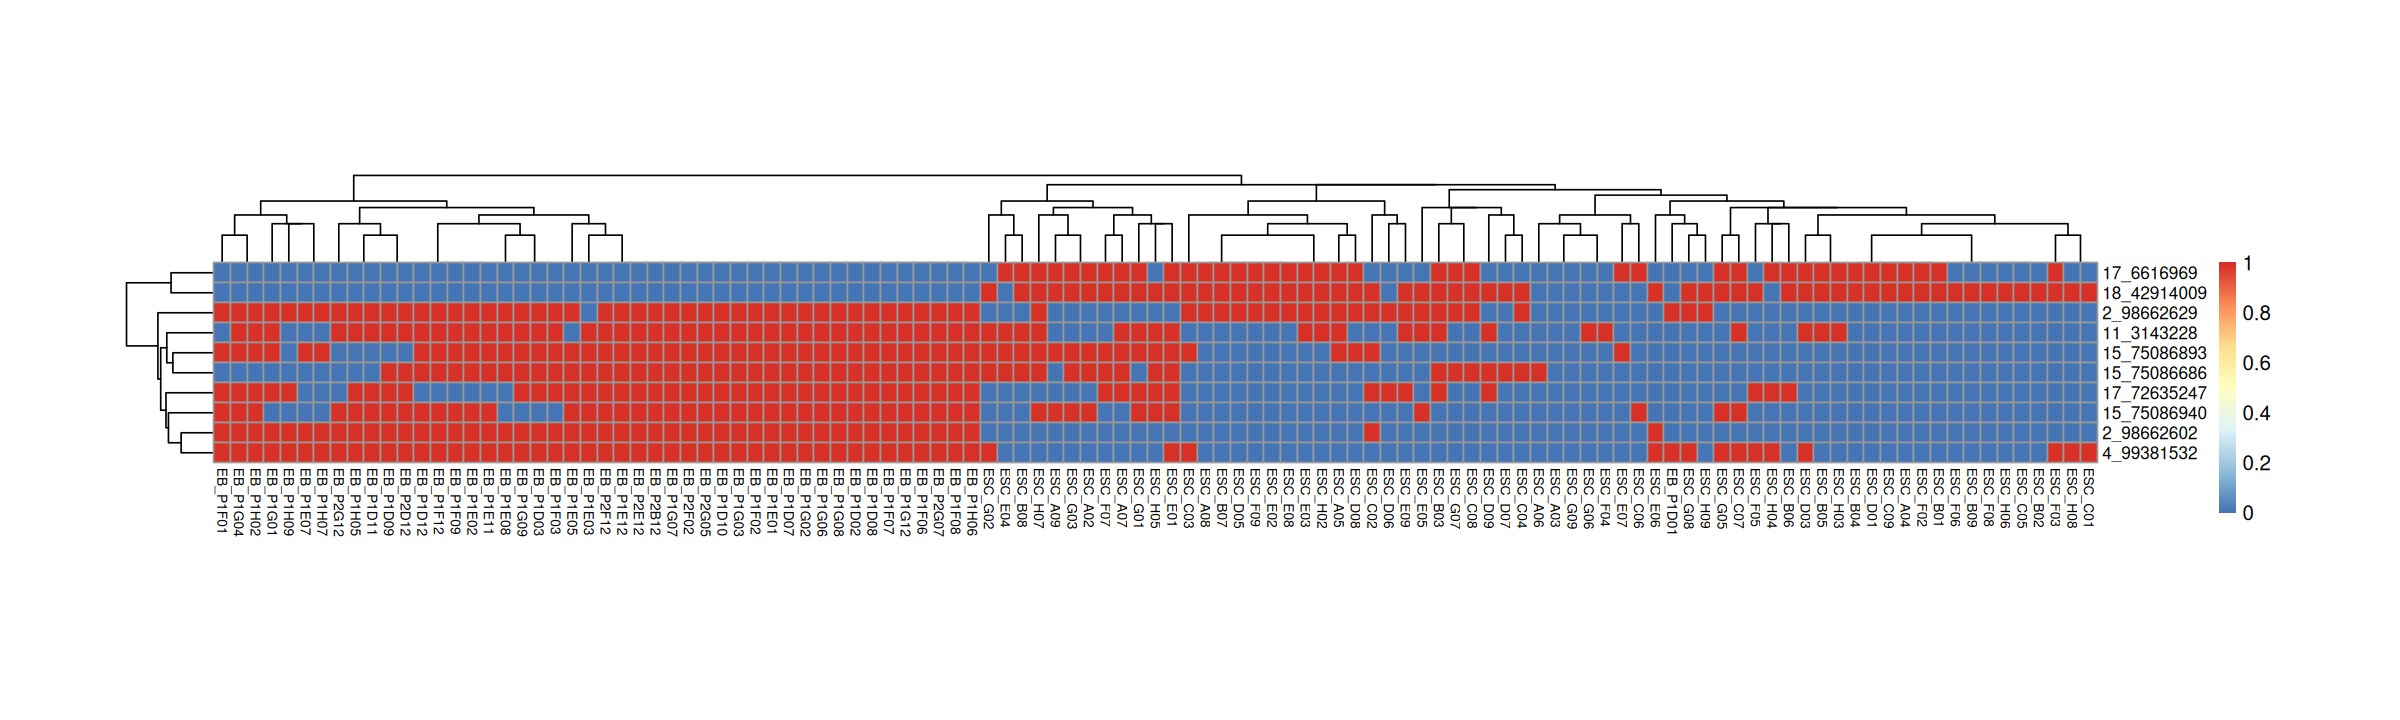

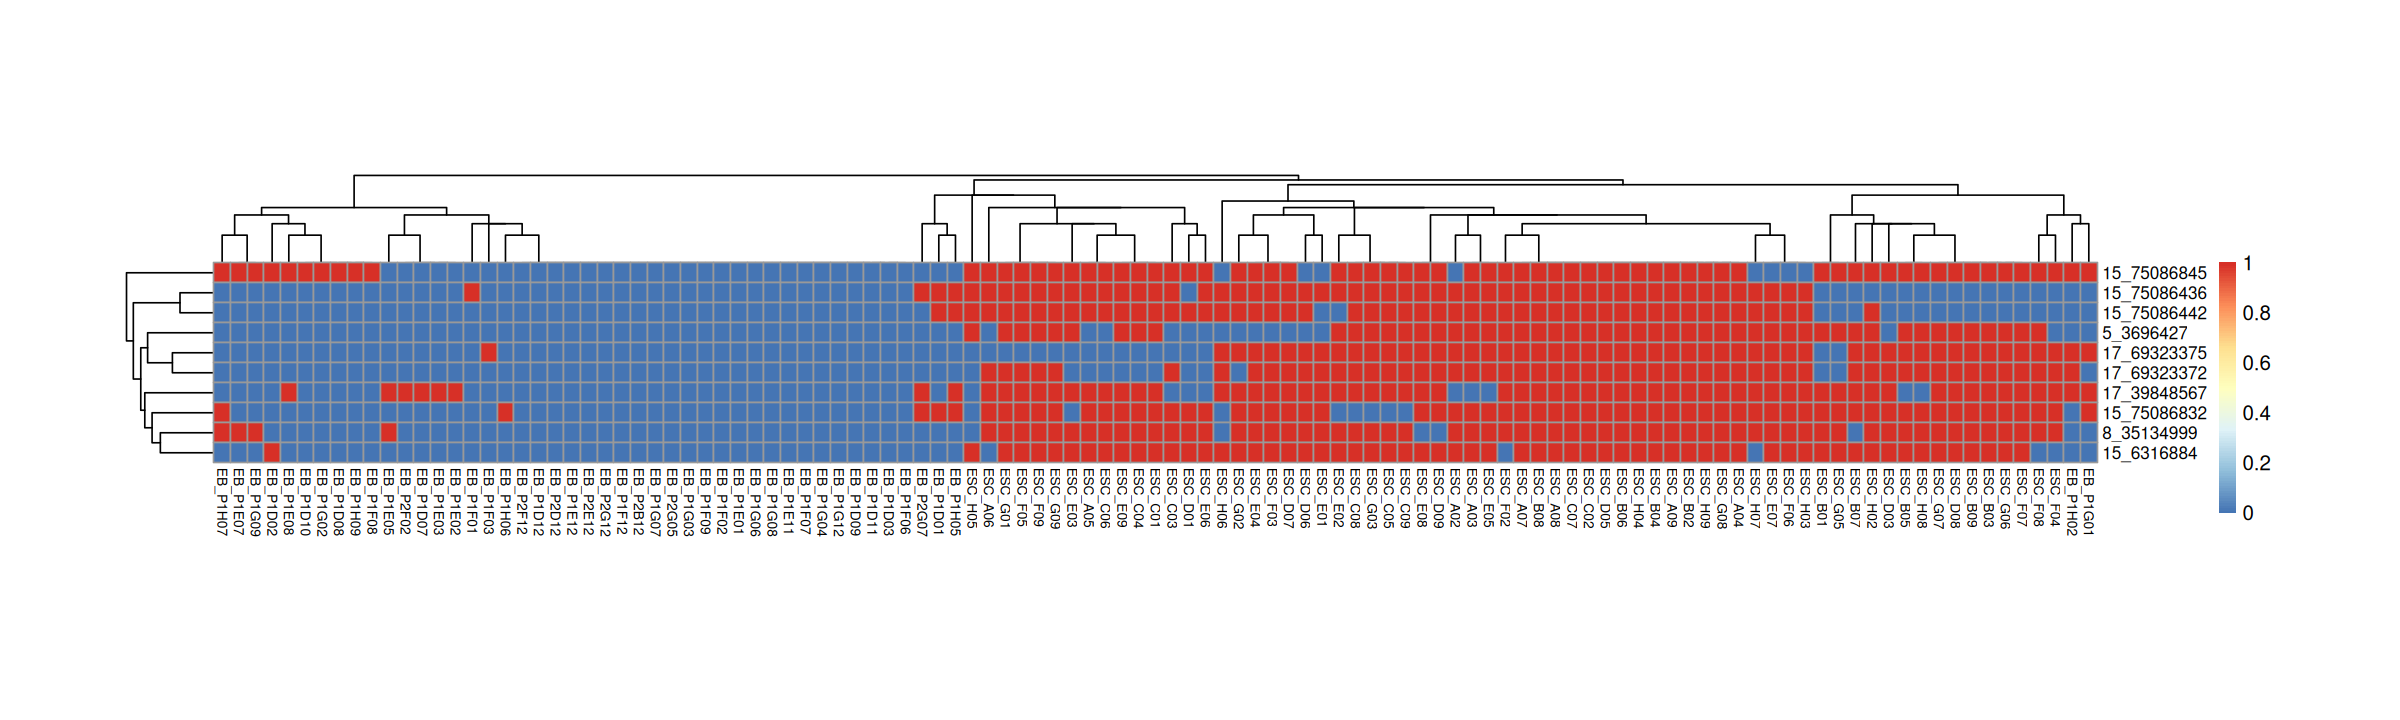

In [50]:
# Make the heatmap larger and wider
plot_data_heatmap(
  object = MOFAobject, 
  view = "scRNAseq", 
  factor = "Factor1", 
  features = 10, 
  transpose = FALSE, 
  show_colnames = TRUE, 
  show_rownames = TRUE,
  cluster_cols = TRUE,
  # Add size parameters
  fontsize = 12,           # Increase font size
  fontsize_row = 10,       # Row label font size
  fontsize_col = 8,        # Column label font size
  cellwidth = 10,          # Width of each cell
  cellheight = 12          # Height of each cell
)

# Make the heatmap larger and wider
plot_data_heatmap(
  object = MOFAobject, 
  view = "scBSseq", 
  factor = "Factor1", 
  features = 10, 
  transpose = FALSE, 
  show_colnames = TRUE, 
  show_rownames = TRUE,
  cluster_cols = TRUE,
  # Add size parameters
  fontsize = 12,           # Increase font size
  fontsize_row = 10,       # Row label font size
  fontsize_col = 8,        # Column label font size
  cellwidth = 10,          # Width of each cell
  cellheight = 12          # Height of each cell
)


# Make the heatmap larger and wider
plot_data_heatmap(
  object = MOFAobject, 
  view = "scATACseq", 
  factor = "Factor1", 
  features = 10, 
  transpose = FALSE, 
  show_colnames = TRUE, 
  show_rownames = TRUE,
  cluster_cols = TRUE,
  # Add size parameters
  fontsize = 12,           # Increase font size
  fontsize_row = 10,       # Row label font size
  fontsize_col = 8,        # Column label font size
  cellwidth = 10,          # Width of each cell
  cellheight = 12          # Height of each cell
)

In [ ]:
# ========================================
# PART 5: VISUALIZE FACTORS
# =========================================

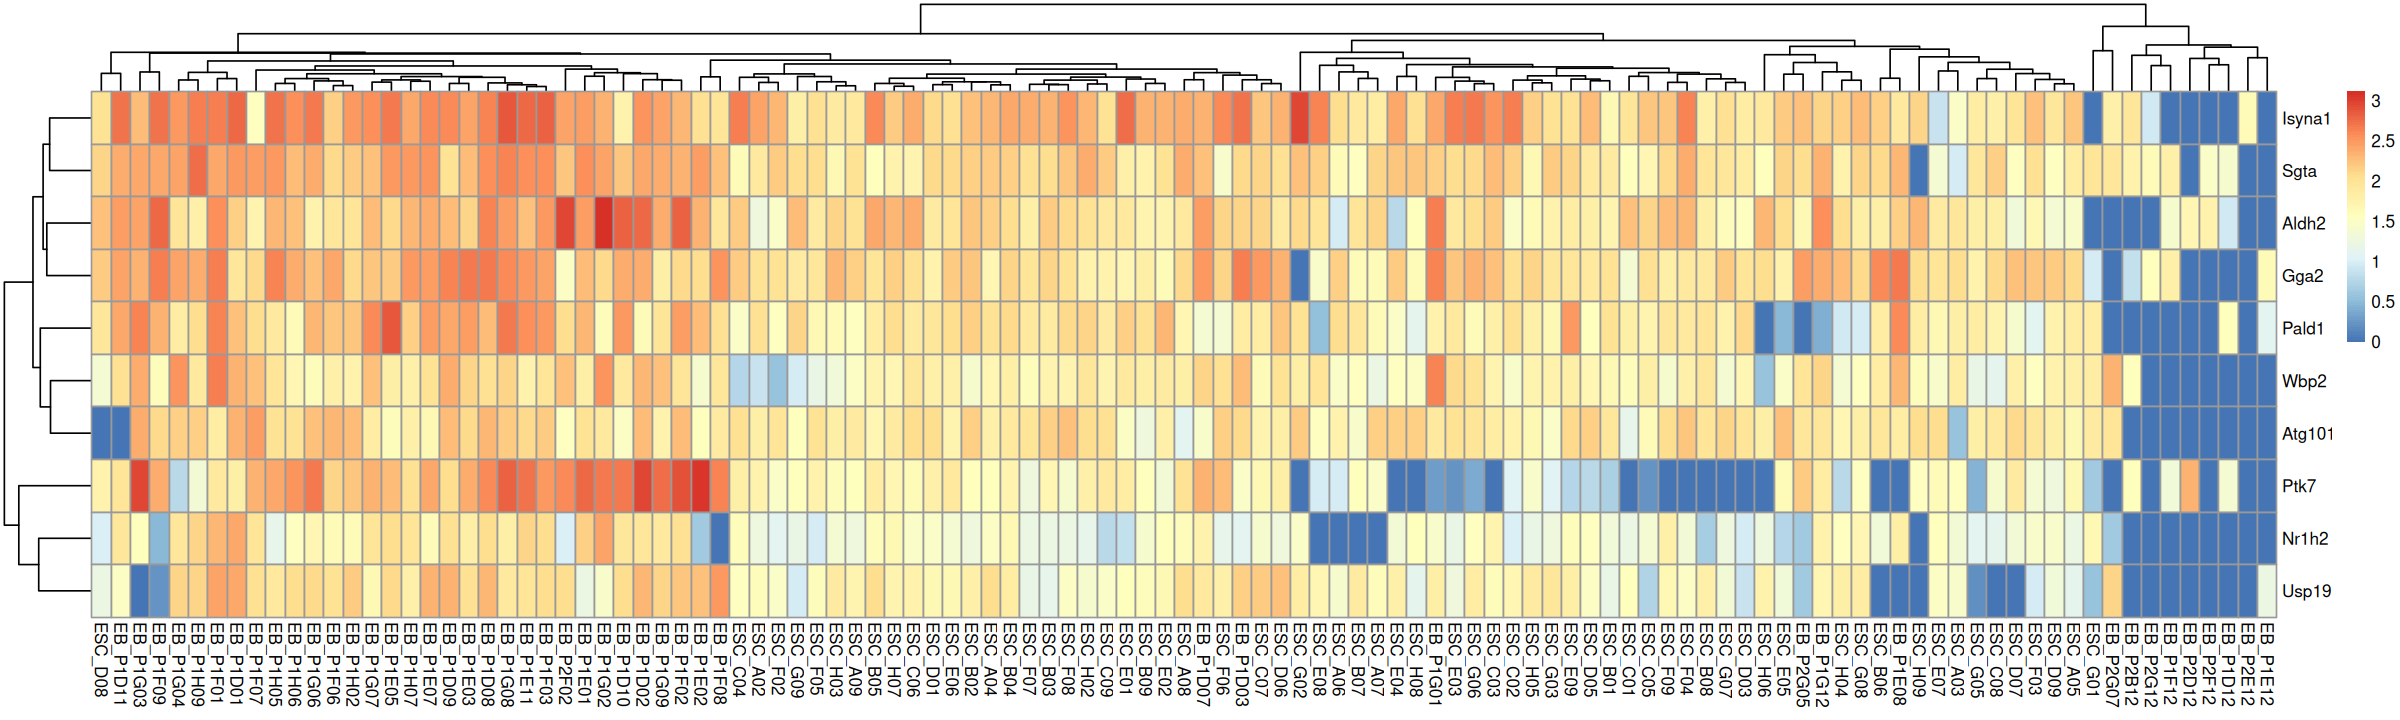

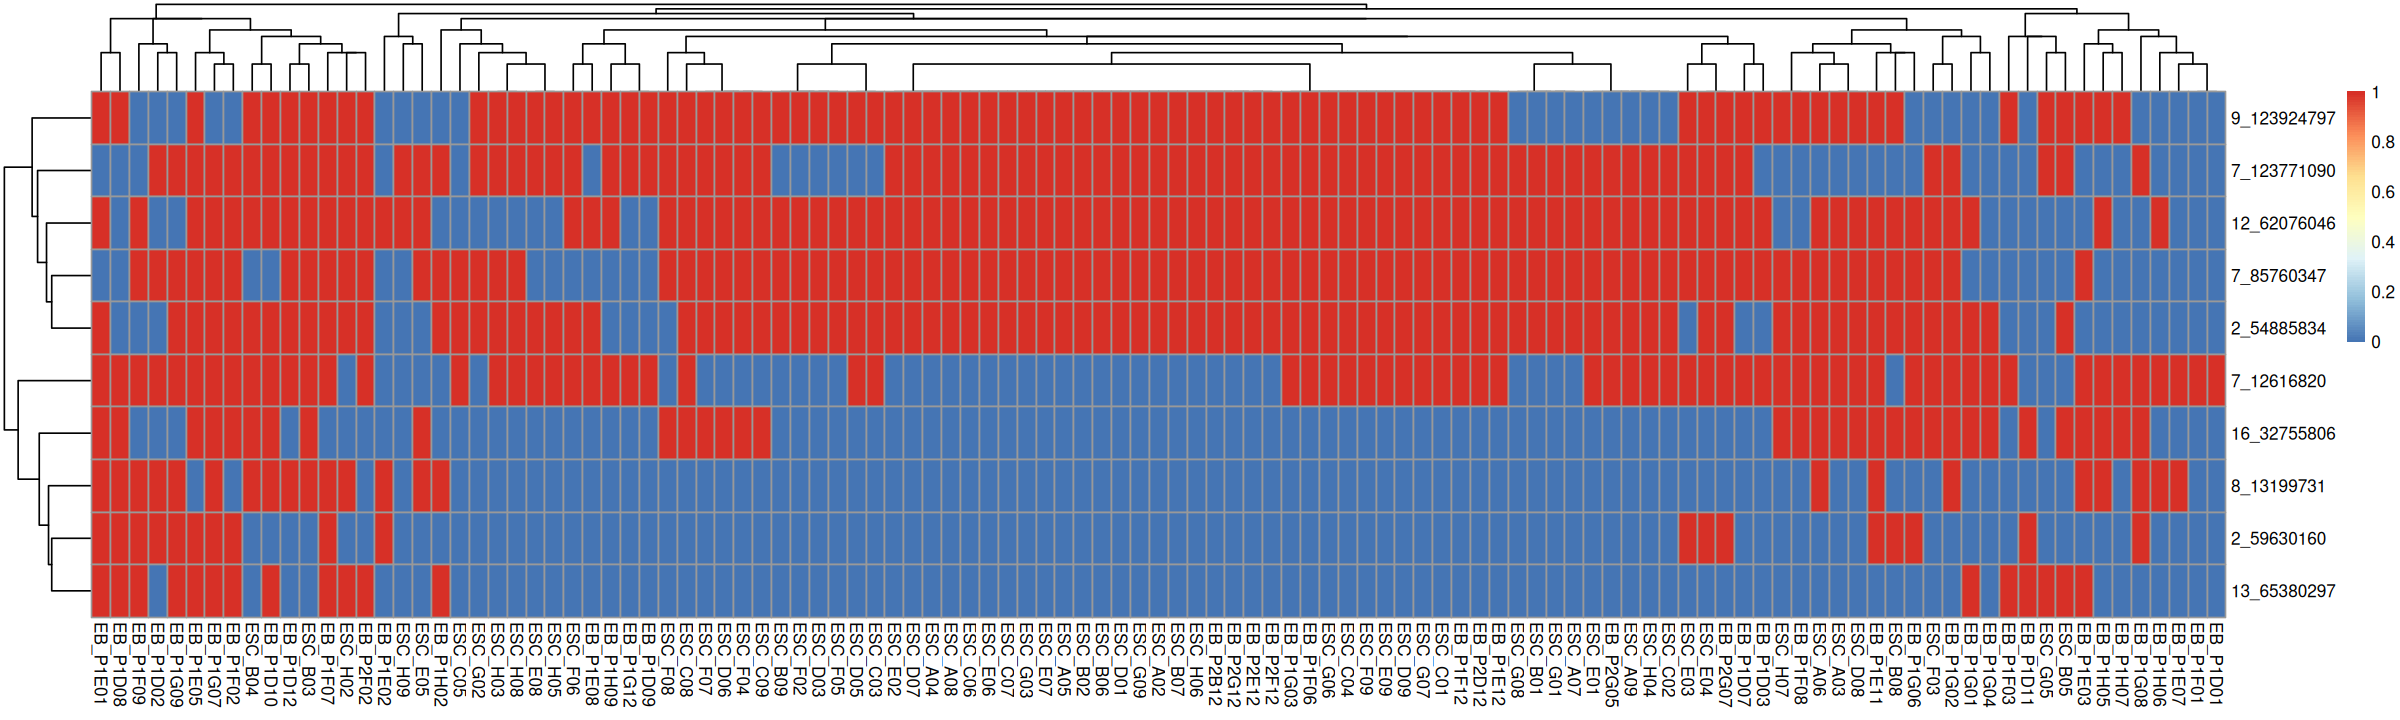

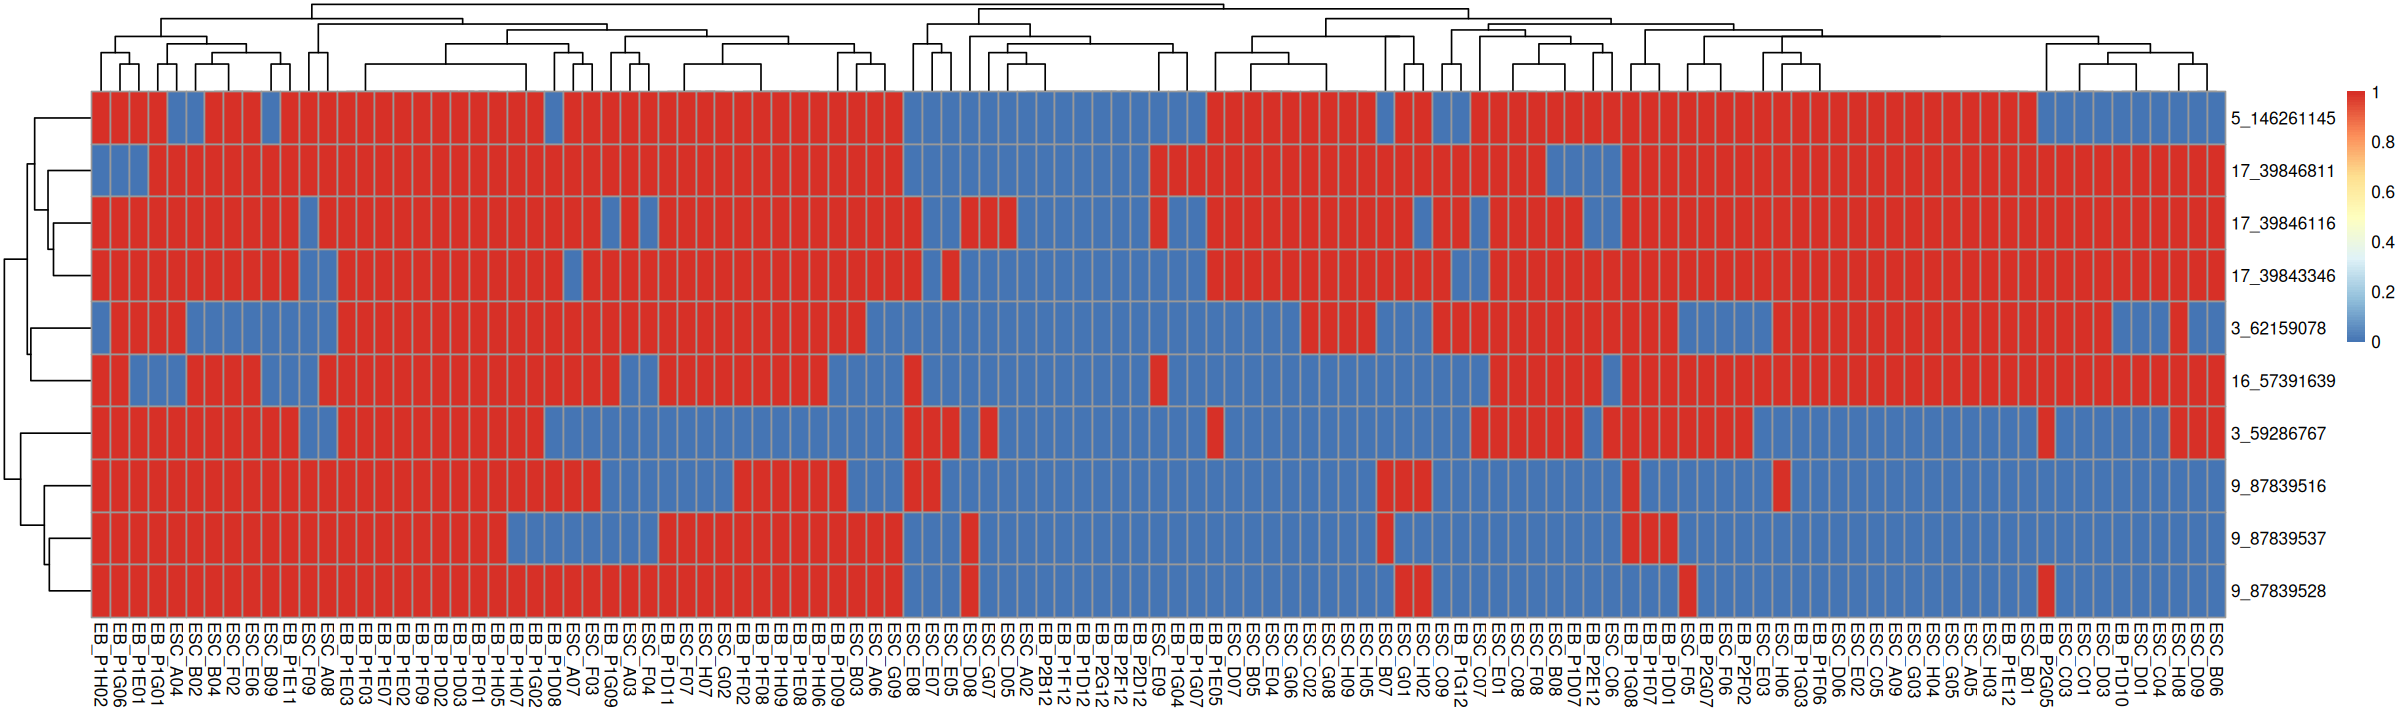

In [54]:
# Plot weights and top features for Factor 2
if(NumFactors >= 1) {
    
  # scRNAseq
  plot_weights(MOFAobject, 
               view = "scRNAseq", 
               factor = 2)
  plot_top_weights(MOFAobject, view = "scRNAseq", 
                   factor = 2, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, view = "scRNAseq", 
                   factor = "Factor2", 
                   features = 10, 
                   transpose = FALSE, 
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
  
  
    # scBSseq
  plot_weights(MOFAobject, 
               view = "scBSseq", 
               factor = 2)
  plot_top_weights(MOFAobject, 
                   view = "scBSseq", 
                   factor = 2, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scBSseq", 
                   factor = "Factor2", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
  
  
    # scATACseq
  plot_weights(MOFAobject, 
               view = "scATACseq", 
               factor = 2)
  plot_top_weights(MOFAobject, 
                   view = "scATACseq", 
                   factor = 2, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scATACseq", 
                   factor = "Factor2", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
}

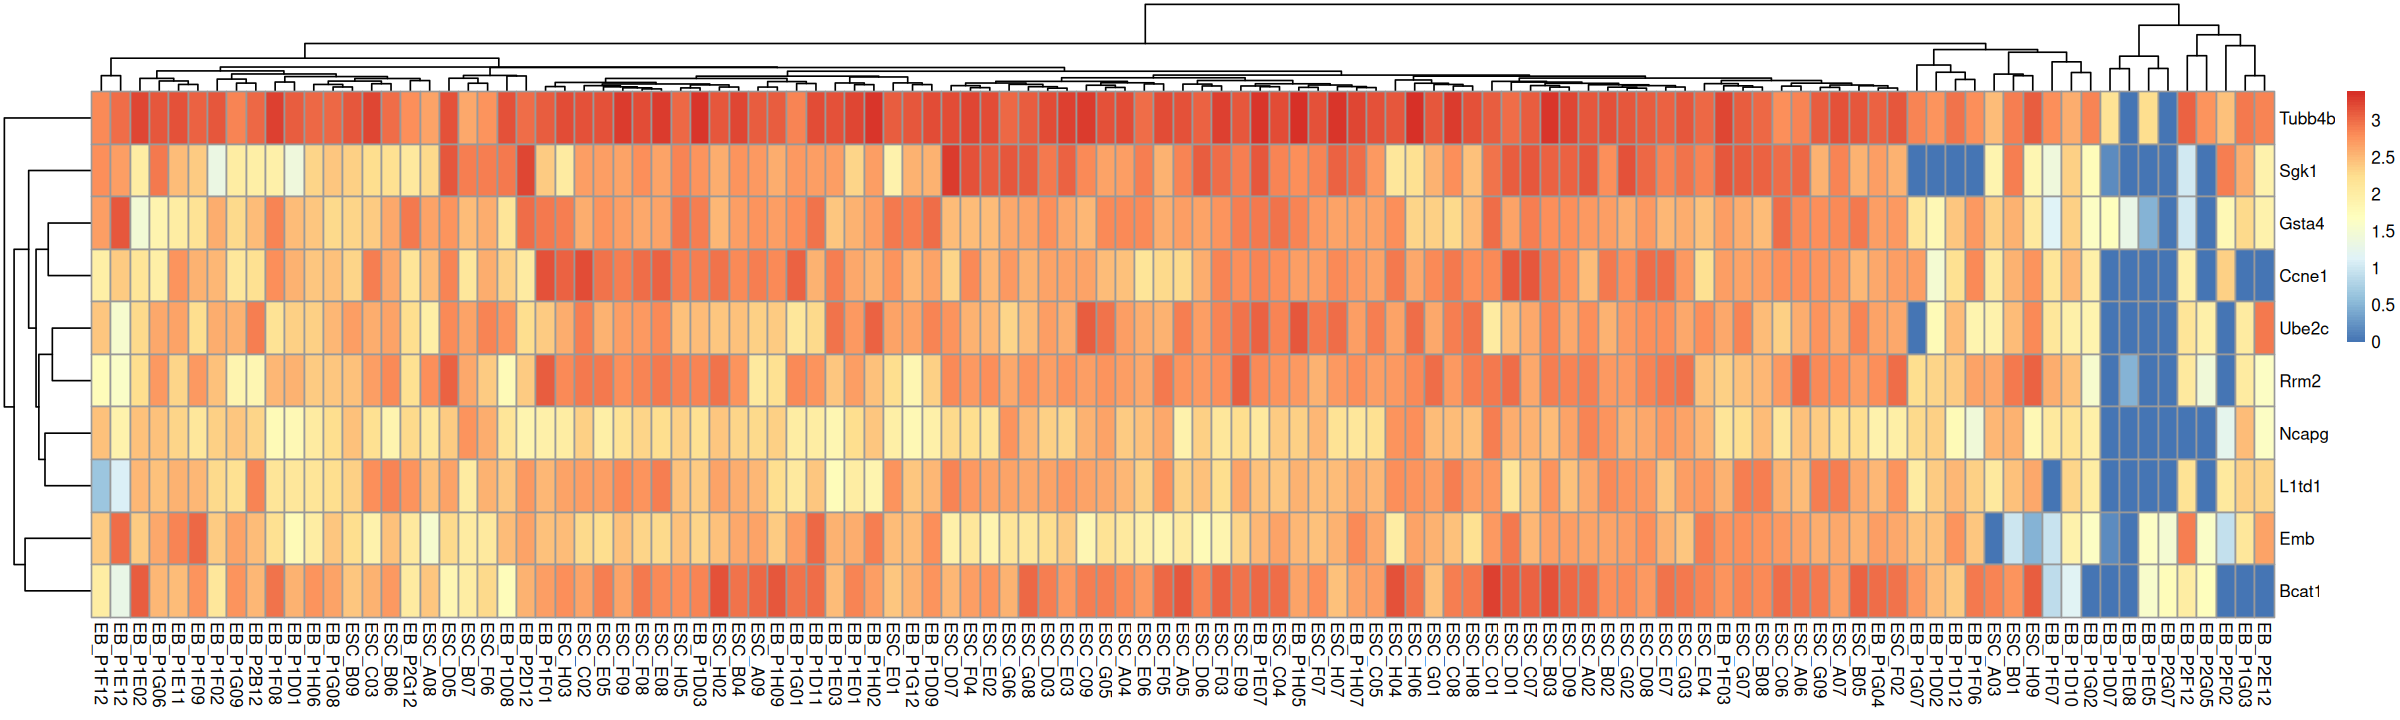

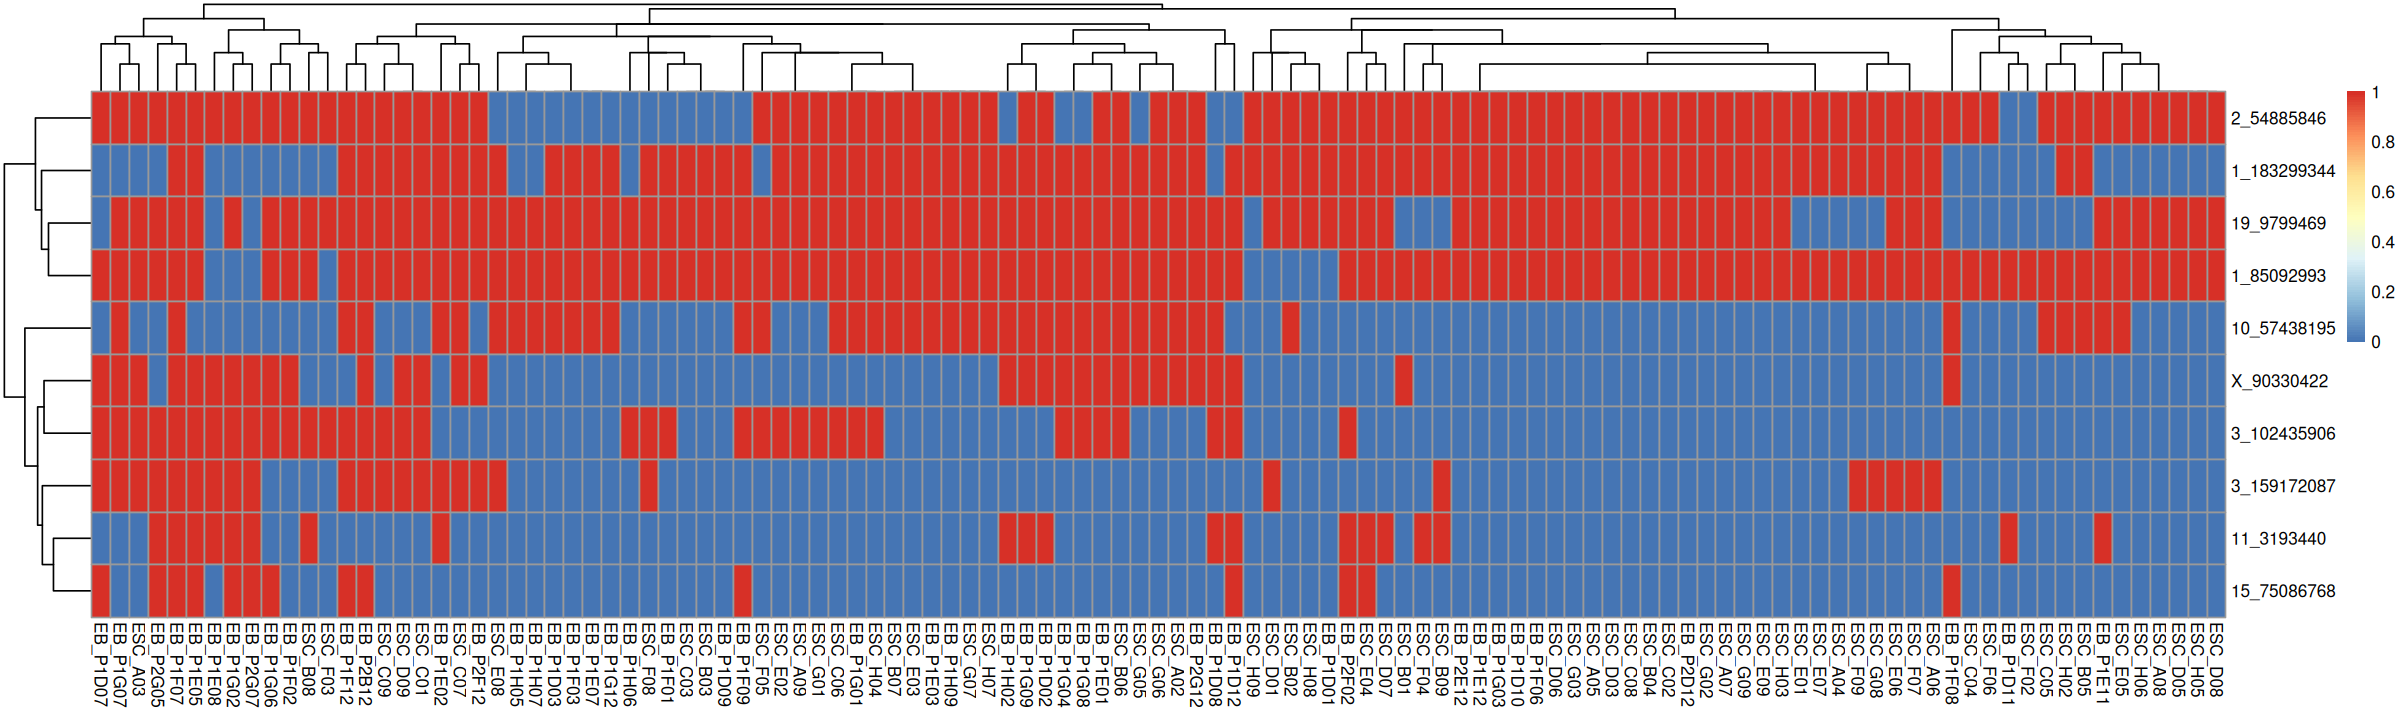

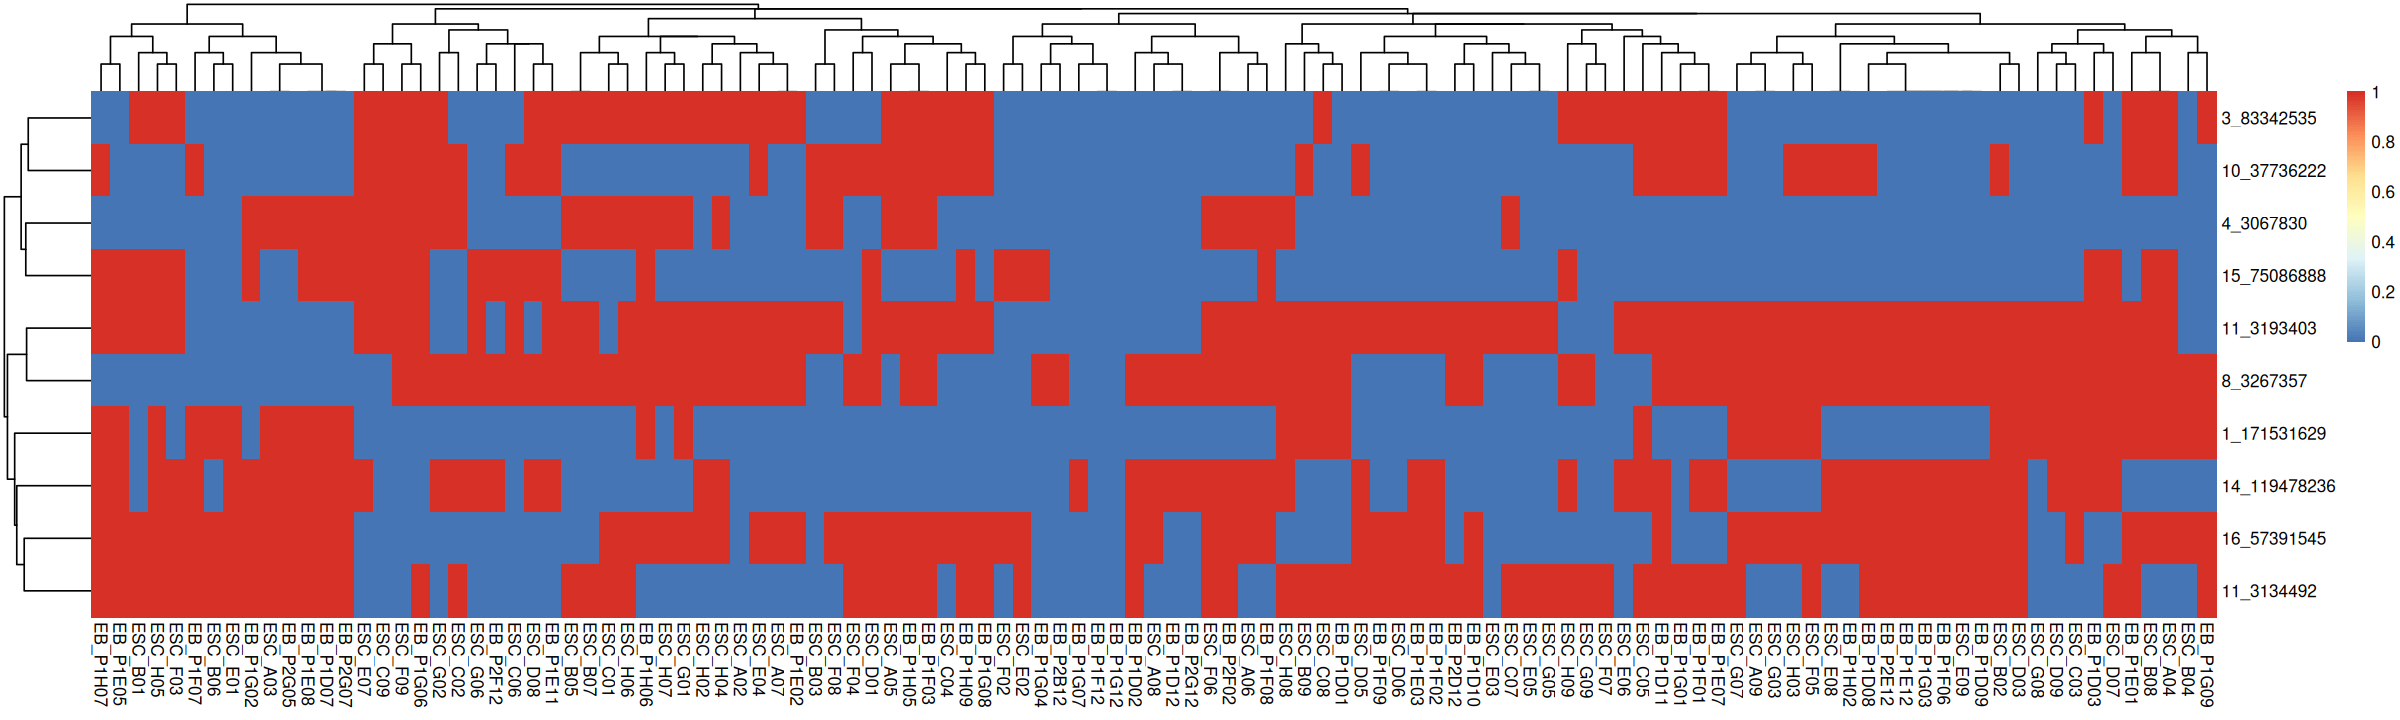

In [52]:
# Plot weights and top features for Factor 3
if(NumFactors >= 1) {
    
  # scRNAseq
  plot_weights(MOFAobject, 
               view = "scRNAseq", 
               factor = 3)
  plot_top_weights(MOFAobject, view = "scRNAseq", 
                   factor = 3, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, view = "scRNAseq", 
                   factor = "Factor3", 
                   features = 10, 
                   transpose = FALSE, 
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
  
  
    # scBSseq
  plot_weights(MOFAobject, 
               view = "scBSseq", 
               factor = 3)
  plot_top_weights(MOFAobject, 
                   view = "scBSseq", 
                   factor = 3, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scBSseq", 
                   factor = "Factor3", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
  
  
    # scATACseq
  plot_weights(MOFAobject, 
               view = "scATACseq", 
               factor = 3)
  plot_top_weights(MOFAobject, 
                   view = "scATACseq", 
                   factor = 3, 
                   nfeatures = 10)
  plot_data_heatmap(MOFAobject, 
                   view = "scATACseq", 
                   factor = "Factor3", 
                   features = 10, 
                   transpose = FALSE,
                   show_colnames = TRUE, 
                   show_rownames = TRUE, 
                   cluster_cols = TRUE)
}

In [ ]:
# ========================================
# PART 6: DIMENSIONALITY REDUCTION
# ========================================

In [56]:
# Let us also display the cells in the low-dimensional latent space:

# Prepare cell type metadata
controls <- c("EB_P1D12", "EB_P1E12", "EB_P1F12", "EB_P1G12", 
              "EB_P2B12", "EB_P2D12", "EB_P2E12", "EB_P2F12", "EB_P2G12",
              "ESC_B12", "ESC_C12", "ESC_D12")

# Get original sample names from scRNAseq
original_names <- colnames(scRNAseq)
modified_names <- ifelse(original_names %in% controls, "CONTROL_CELL", original_names)
cell_types <- matrix(unlist(strsplit(modified_names, "_")), ncol = 2, byrow = TRUE)[, 1]

# Add metadata to MOFA object
sample_metadata <- data.frame(
  sample = samples_names(MOFAobject)[[1]],
  condition = cell_types
)
samples_metadata(MOFAobject) <- sample_metadata

cat("\n=== Sample Metadata ===\n")
print(head(samples_metadata(MOFAobject), n = 5))
print(samples_metadata(MOFAobject))


=== Sample Metadata ===
   sample condition  group
1 ESC_A02       ESC group1
2 ESC_A03       ESC group1
3 ESC_A04       ESC group1
4 ESC_A05       ESC group1
5 ESC_A06       ESC group1
      sample condition  group
1    ESC_A02       ESC group1
2    ESC_A03       ESC group1
3    ESC_A04       ESC group1
4    ESC_A05       ESC group1
5    ESC_A06       ESC group1
6    ESC_A07       ESC group1
7    ESC_A08       ESC group1
8    ESC_A09       ESC group1
9    ESC_B01       ESC group1
10   ESC_B02       ESC group1
11   ESC_B03       ESC group1
12   ESC_B04       ESC group1
13   ESC_B05       ESC group1
14   ESC_B06       ESC group1
15   ESC_B07       ESC group1
16   ESC_B08       ESC group1
17   ESC_B09       ESC group1
18   ESC_C01       ESC group1
19   ESC_C02       ESC group1
20   ESC_C03       ESC group1
21   ESC_C04       ESC group1
22   ESC_C05       ESC group1
23   ESC_C06       ESC group1
24   ESC_C07       ESC group1
25   ESC_C08       ESC group1
26   ESC_C09       ESC group1
27 

In [57]:
# Run UMAP and t-SNE
set.seed(12345)
MOFAobject <- run_umap(MOFAobject, 
                      n_neighbors = round(sqrt(length(cell_types)), 0), 
                      min_dist = 1)
MOFAobject <- run_tsne(MOFAobject, 
                      perplexity = round(sqrt(length(cell_types)), 0))

In [59]:
# Increase the plot window size
options(repr.plot.width = 6, repr.plot.height = 6)  # For Jupyter

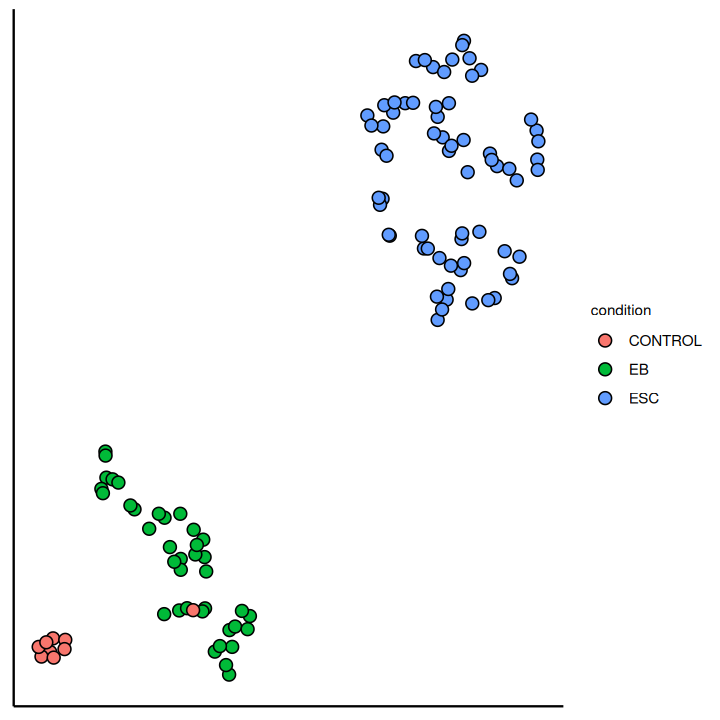

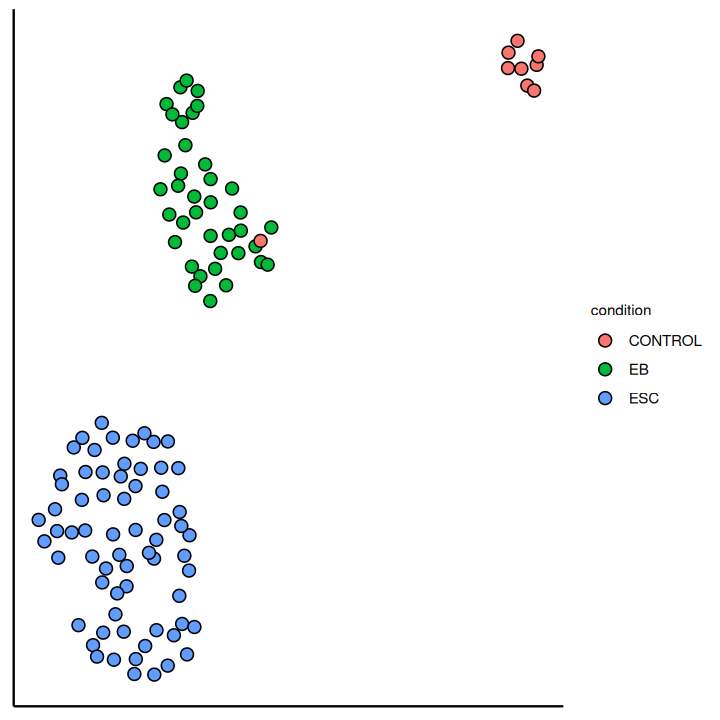

In [60]:
# Plot dimensionality reduction
plot_dimred(MOFAobject, 
            method = "TSNE", 
            dot_size = 3, color_by = "condition")
plot_dimred(MOFAobject, 
            method = "UMAP", 
            dot_size = 3, color_by = "condition")



In [ ]:
# Input space = MOFA factor matrix (K factors × 113 samples)
# Output = nonlinear embedding of the latent space
# Colors = biological condition (ESC, EB, CONTROL)
# No labels were used to train MOFA → this is post-hoc validation

In [ ]:
#  High-level interpretation (both plots)

# 🔵 ESC (blue)
# Forms a tight, compact cluster
# Clearly separated from EB and CONTROL

# Indicates:
# low heterogeneity
# stable molecular state
# strong shared signal across omics
# 👉 ESCs are molecularly homogeneous and well captured by MOFA

# 🟢 EB (green)
# More spread out
# Occupies an intermediate region
# Some internal structure
# 👉 EBs are heterogeneous, consistent with:

# differentiation trajectories
# mixed epigenetic and transcriptional states

# 🔴 CONTROL (red)
# Small cluster
# Well separated from ESC
# Slightly closer to EB than ESC (depending on view)
# 👉 Controls represent a distinct, non-pluripotent baseline state

In [90]:
# Increase the plot window size
options(repr.plot.width = 6, repr.plot.height = 6)  # For Jupyter

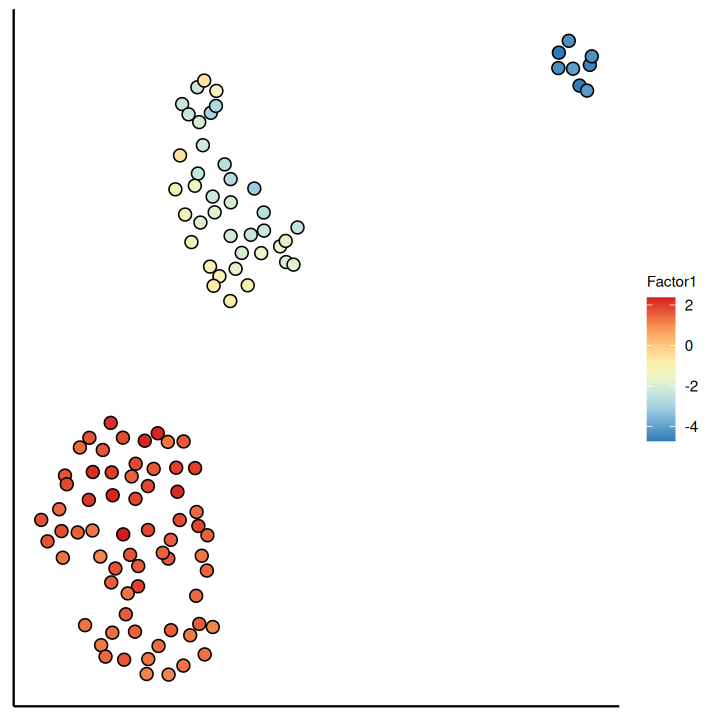

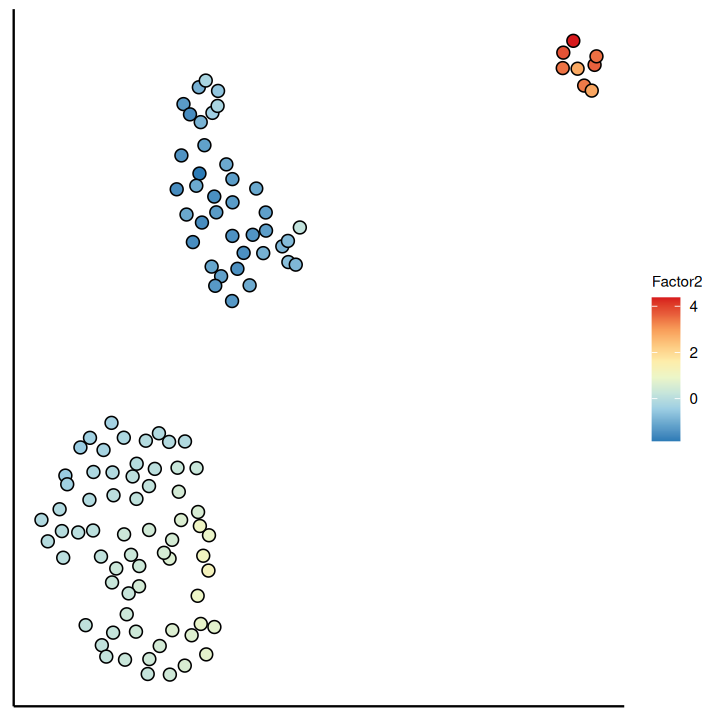

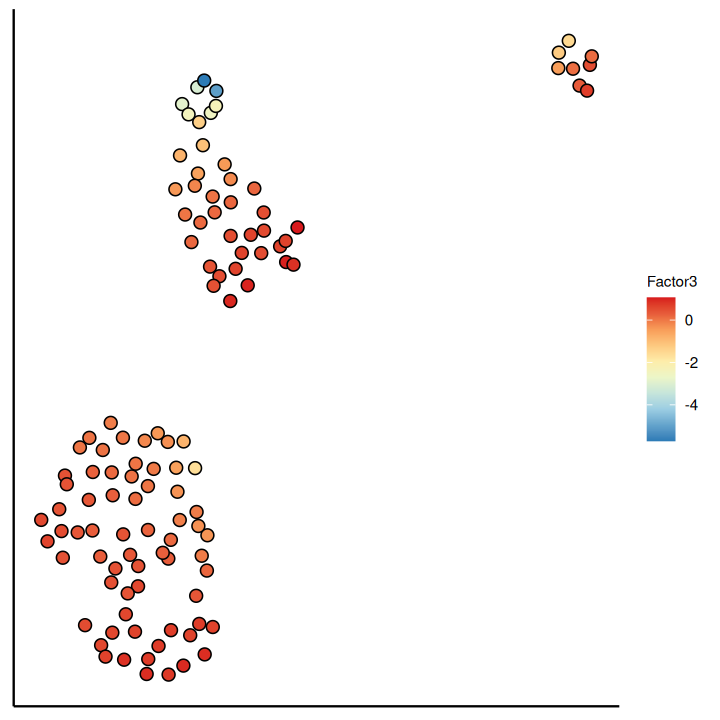

In [91]:
# Plot factors in UMAP space
if(NumFactors >= 1) {
  plot_dimred(MOFAobject, method = "UMAP", dot_size = 3, color_by = "Factor1")
}
if(NumFactors >= 2) {
  plot_dimred(MOFAobject, method = "UMAP", dot_size = 3, color_by = "Factor2")
}
if(NumFactors >= 3) {
  plot_dimred(MOFAobject, method = "UMAP", dot_size = 3, color_by = "Factor3")
}


In [ ]:
# Panel 1️⃣: UMAP colored by Factor 1
# What you see

# One cluster is strongly red/orange (high Factor1)
# Another cluster is deep blue (low Factor1)
# Very sharp contrast, little gradient
# Interpretation
# Factor 1 is a dominant, binary-like axis
# It cleanly separates two major cell states
# Minimal within-group variation
# Biological meaning (given your earlier plots)
# Factor 1 captures the primary pluripotency vs non-pluripotency axis, driven jointly by scRNA, scATAC, and scBS.
# This matches:
# earlier LF1 vs LF2 scatter
# feature heatmaps
# ESC vs EB separation
# ✅ This is your main biological factor

# Panel 2️⃣: UMAP colored by Factor 2
# What you see

# A gradient rather than a hard split
# One group has high Factor2
# Another group has low Factor2
# More spread within clusters
# Interpretation
# Factor 2 captures heterogeneity within non-ESC cells
# Not a simple on/off switch
# Reflects continuous variation
# Biological meaning
# Factor 2 likely represents differentiation progression or lineage priming within embryoid bodies (EBs).
# This is consistent with:
# EB cells being heterogeneous
# epigenetic remodeling during differentiation
# scRNA-driven variation (as you saw earlier)
# ✅ This is a secondary, within-group factor

# Panel 3️⃣: UMAP colored by Factor 3 (if shown / implied)
# What you would typically observe
# Much weaker contrast
# Mixed colors across clusters
# No clean separation
# Interpretation
# Factor 3 explains smaller, global variation
# Possibly:
# cell cycle
# technical effects
# subtle transcriptional programs
# Biological meaning
# Factor 3 is not defining cell identity, but modulates states across all cells.
# This is normal and expected.

In [92]:
cat("\n=== MOFA Analysis Complete! ===\n")

# Print session info
sessionInfo()


=== MOFA Analysis Complete! ===


R version 4.3.3 (2024-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 24.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.12.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] MOFA2_1.12.1    mixOmics_6.26.0 ggplot2_3.5.2   lattice_0.22-5 
[5] MASS_7.3-60.0.1

loaded via a namespace (and not attached):
 [1] gtable_0.3.6          dir.expiry_1.8.0      ellipse_0.5.0        
